In [2]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 51.0 MB/s eta 0:00:00


**Imorting Files**

In [3]:
import os
from google.colab import files

required_files = {
    'train_file': '/content/train.En.csv',
    'test_file': '/content/task_A_En_test.csv'
}

missing_files = []

for key, path in required_files.items():
    if not os.path.exists(path):
        print(f"File '{path}' not found.")
        missing_files.append(key)
    else:
        print(f"File '{path}' found.")

if missing_files:

    for name in missing_files:
        print("Please upload the missing file : ",name)
        uploaded = files.upload()
else:
    print("All required files found.")

File '/content/train.En.csv' not found.
File '/content/task_A_En_test.csv' not found.
Please upload the missing file :  train_file


Saving train.En.csv to train.En.csv
Please upload the missing file :  test_file


Saving task_A_En_test.csv to task_A_En_test.csv


**Importing Libraries**

In [4]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords,wordnet
from nltk import pos_tag, word_tokenize
import seaborn as sns
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import  GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import gensim
from nltk.tokenize import sent_tokenize, word_tokenize

**Exploratory Data Analysis**

In [5]:
df = pd.read_csv('/content/train.En.csv',index_col=0)

print(df.shape)
print("Columns : ",list(df.columns.values))
print("Head : ",df.head())
print("Info : ",df.info())
print("Describe : ",df.describe())
print("NaN tweet line : ",df[df["tweet"]==np.nan])
print("Duplicates Count : ",df.duplicated().sum())


(3468, 9)
Columns :  ['tweet', 'sarcastic', 'rephrase', 'sarcasm', 'irony', 'satire', 'understatement', 'overstatement', 'rhetorical_question']
Head :                                                 tweet  sarcastic  \
0  The only thing I got from college is a caffein...          1   
1  I love it when professors draw a big question ...          1   
2  Remember the hundred emails from companies whe...          1   
3  Today my pop-pop told me I was not “forced” to...          1   
4  @VolphanCarol @littlewhitty @mysticalmanatee I...          1   

                                            rephrase  sarcasm  irony  satire  \
0  College is really difficult, expensive, tiring...      0.0    1.0     0.0   
1  I do not like when professors don’t write out ...      1.0    0.0     0.0   
2  I, at the bare minimum, wish companies actuall...      0.0    1.0     0.0   
3  Today my pop-pop told me I was not "forced" to...      1.0    0.0     0.0   
4  I would say Ted Cruz is an asshole and doe

**Labels Distribution**

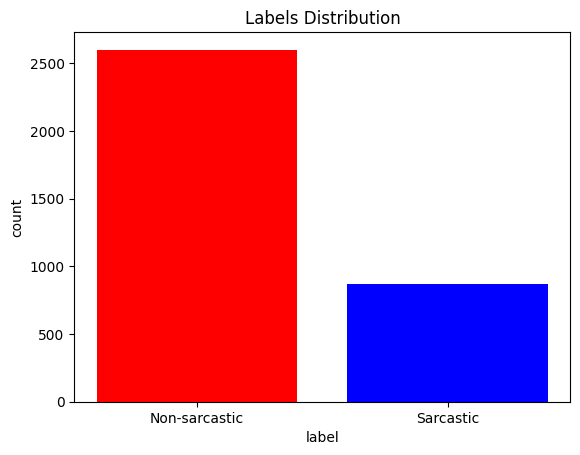

Non-sarcastic Percentage :  75.0 %
Sarcastic Percentage :  25.0 %


In [6]:
plt.bar(["Non-sarcastic","Sarcastic"],df["sarcastic"].value_counts(),color=["red","blue"])
plt.title("Labels Distribution")
plt.xlabel("label")
plt.ylabel("count")
plt.show()
sarcastic_percentage = (df["sarcastic"].value_counts()[1]/df.shape[0])*100
non_sarcastic_percentage = 100-sarcastic_percentage
print("Non-sarcastic Percentage : ",non_sarcastic_percentage,"%")
print("Sarcastic Percentage : ",sarcastic_percentage,"%")


**Sarcasm types Distribution**

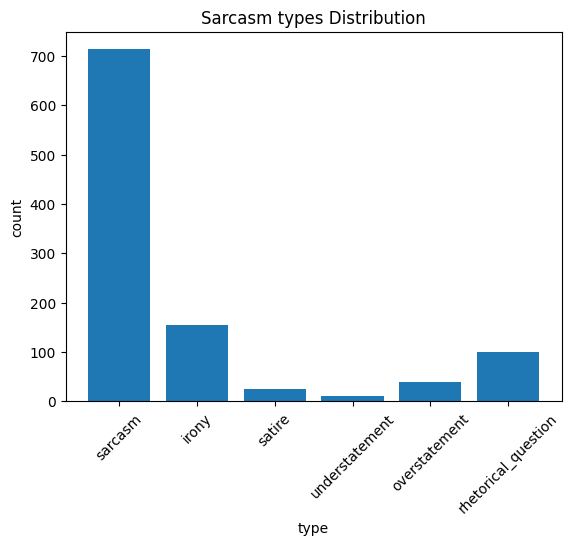

In [7]:
plt.bar(df.columns[3:],df.iloc[:,3:].sum())
plt.title("Sarcasm types Distribution")
plt.xlabel("type")
plt.ylabel("count")
plt.xticks(rotation=45)
plt.show()

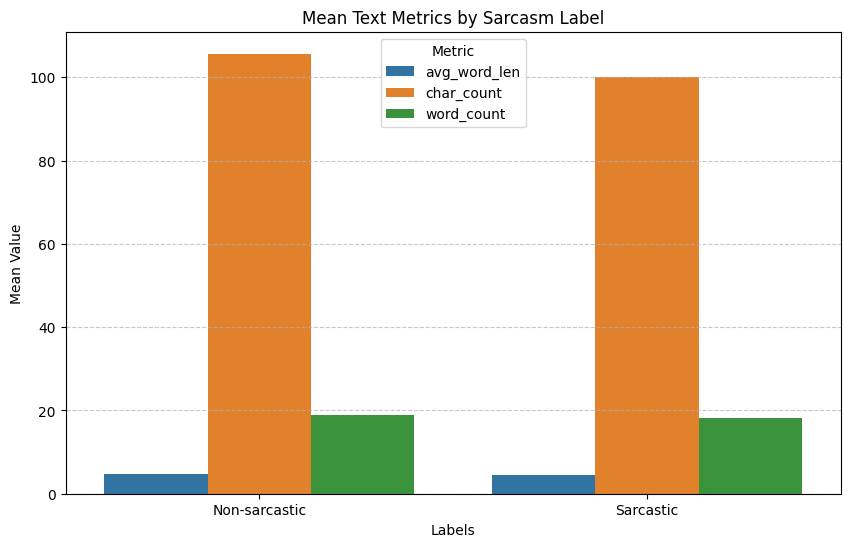

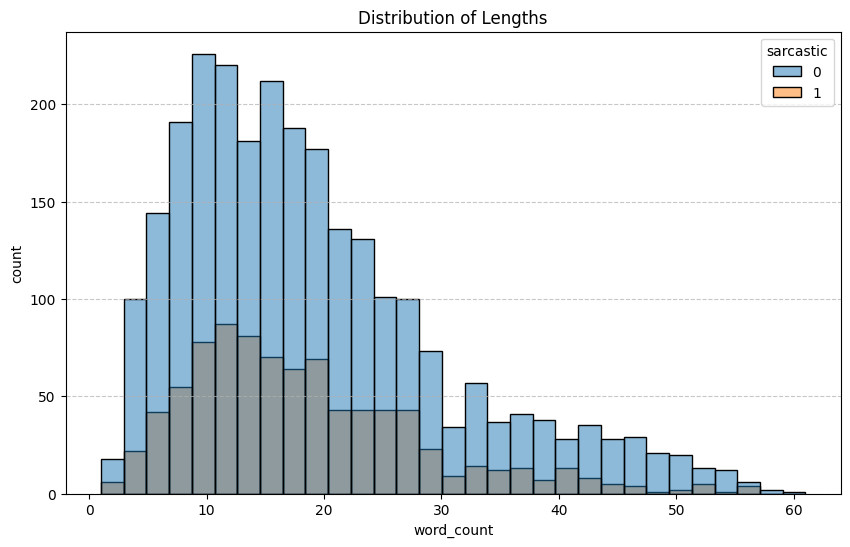

In [8]:

df.dropna(subset="tweet",inplace=True)
df['char_count'] = df['tweet'].apply(len)
df['word_count'] = df['tweet'].apply(lambda x: len(x.split()))
df['avg_word_len'] = df['tweet'].apply(lambda x: np.mean([len(w) for w in x.split()]) if x.split() else 0)
df['char_count'] = df['tweet'].apply(len)

pivot  = df.pivot_table(index='sarcastic', values=['char_count', 'word_count', 'avg_word_len'],aggfunc="mean").reset_index()
pivot = pivot.melt(id_vars='sarcastic', var_name='Metric', value_name='Mean Value')
plt.figure(figsize=(10, 6))
sns.barplot(x='sarcastic', y='Mean Value', hue='Metric', data=pivot)
plt.title('Mean Text Metrics by Sarcasm Label')
plt.xlabel('Labels')
plt.ylabel('Mean Value')
plt.xticks(ticks=[0, 1], labels=['Non-sarcastic', 'Sarcastic'])
plt.legend(title='Metric')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df[["sarcastic","word_count"]],x="word_count",hue="sarcastic",stat="count")
plt.title("Distribution of Lengths")
plt.xlabel("word_count")
plt.ylabel("count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Word Cloud**

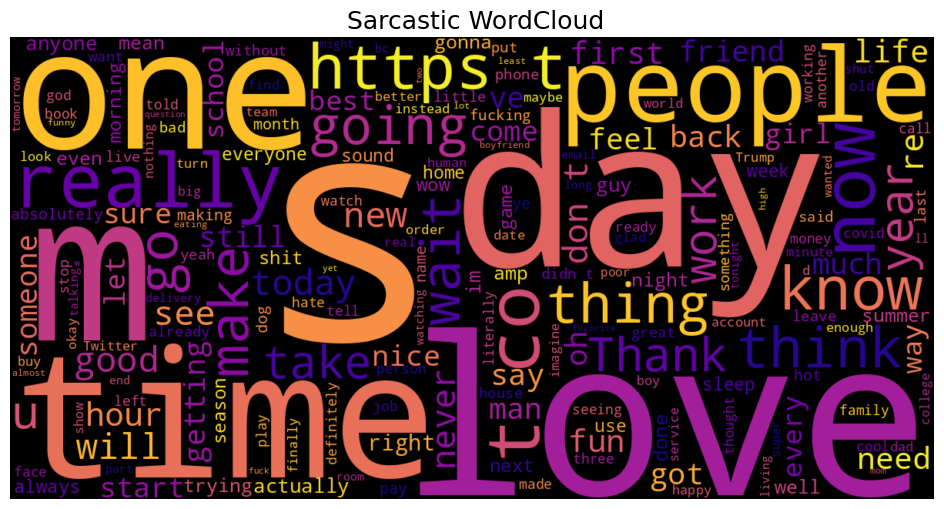

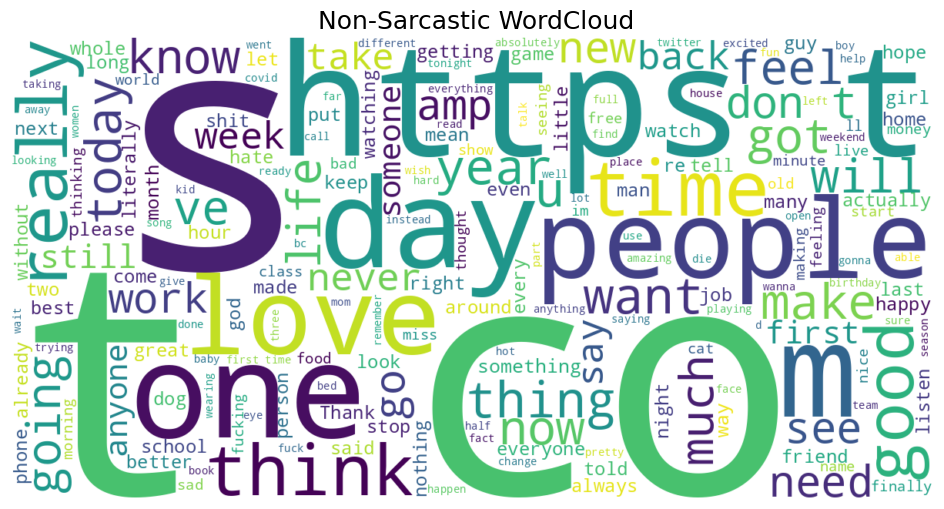

In [9]:
sarcastic = "".join(df[df["sarcastic"]==1]["tweet"])
non_sarcastic = "".join(df[df["sarcastic"]==0]["tweet"])
sarcastic = ' '.join(word for word in sarcastic.split())
non_sarcastic = ' '.join(word for word in non_sarcastic.split())

wordcloud= WordCloud(
    width=1200,
    height=600,
    background_color='black',
    colormap='plasma',
    relative_scaling=0.5,
    min_font_size=10
).generate(sarcastic)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(' Sarcastic WordCloud', fontsize=18)
plt.axis('off')
plt.show()

wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    colormap='viridis',
    relative_scaling=0.5,
    min_font_size=10
).generate(non_sarcastic)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(' Non-Sarcastic WordCloud', fontsize=18)
plt.axis('off')
plt.show()




**Data PreProcessing**

In [10]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
top_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def get_wordnet_pos(tag):
    if tag.startswith('J'): return wordnet.ADJ
    if tag.startswith('V'): return wordnet.VERB
    if tag.startswith('N'): return wordnet.NOUN
    if tag.startswith('R'): return wordnet.ADV
    return wordnet.NOUN
def clean_text(text):
  text = str(text).lower()
  text = re.sub(r'http\S+|www\S+', ' ', text)
  text = re.sub(r'[^a-z0-9\s\!\?]', ' ', text)
  text = re.sub(r'\s+', ' ', text).strip()
  text = ' '.join(word for word in text.split() if word not in top_words)
  tokens = word_tokenize(text)
  # This return  every token with its wordnet (adj, noun ...)
  pos_tags = pos_tag(tokens)
  lemmatized_tokens = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in pos_tags]
  text = ' '.join(lemmatized_tokens)
  return text

df["clean_text"] = df['tweet'].apply(clean_text)
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question,char_count,word_count,avg_word_len,clean_text
0,The only thing I got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0.0,1.0,0.0,0.0,0.0,0.0,57,11,4.272727,thing get college caffeine addiction
1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0,133,26,4.153846,love professor draw big question mark next ans...
2,Remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0.0,1.0,0.0,0.0,0.0,0.0,236,36,5.583333,remember hundred email company covid start get...
3,Today my pop-pop told me I was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1.0,0.0,0.0,0.0,0.0,0.0,80,17,3.764706,today pop pop told force go college okay sure ...
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I would say Ted Cruz is an asshole and doesn’t...,1.0,0.0,0.0,0.0,0.0,0.0,193,29,5.689655,volphancarol littlewhitty mysticalmanatee also...


**Word Embedding/Vectorization**

In [11]:
X_train = df["clean_text"].values
y_train = df["sarcastic"].values

# Vectorization (do this FIRST, before any resampling or scaling)
cv = CountVectorizer(max_features=3000, ngram_range=(1,2))
X_train_cv = cv.fit_transform(X_train)
print("BOW shape:", X_train_cv.shape)

tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
print("TF-IDF shape:", X_train_tfidf.shape)

# Resampling for KNN only (KNN is sensitive to class imbalance)
# For other models, we use class_weight='balanced' instead
adasyn_knn = ADASYN(random_state=42)
x_train_cv_res, y_train_cv_res = adasyn_knn.fit_resample(X_train_cv, y_train)
x_train_tfidf_res, y_train_tfidf_res = ADASYN(random_state=42).fit_resample(X_train_tfidf, y_train)
print("BOW after resample for KNN:", y_train_cv_res.shape)
print("TF-IDF after resample for KNN:", y_train_tfidf_res.shape)

# Scaling

# note that knn requires the resampled date , so we will specify a unique scaler for it
knn_bow_scaler = StandardScaler(with_mean=False)
knn_tfidf_scaler = StandardScaler(with_mean=False)
knn_w2v_scaler = StandardScaler(with_mean=True)

x_train_cv_res = knn_bow_scaler.fit_transform(x_train_cv_res)
x_train_tfidf_res = knn_tfidf_scaler.fit_transform(x_train_tfidf_res)




bow_scaler = StandardScaler(with_mean=False)
tfidf_scaler = StandardScaler(with_mean=False)
w2v_scaler = StandardScaler(with_mean=True)

X_train_cv_scaled = bow_scaler.fit_transform(X_train_cv)
X_train_tfidf_scaled = tfidf_scaler.fit_transform(X_train_tfidf)

BOW shape: (3467, 5000)
TF-IDF shape: (3467, 5000)
BOW after resample for KNN: (5289,)
TF-IDF after resample for KNN: (5436,)


**Defining grid search parameters**

In [12]:
grid_params = {
    "KNN": {
        'n_neighbors': range(1, 12)
    },
    "LogisticRegression": {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga'],
        'class_weight': ['balanced']
    },
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto'],
        'class_weight': ['balanced']
    },
    "RandomForest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'class_weight': ['balanced']
    },
    "NaiveBayes": {
    }
}

**Defining Generic Function for Model Training and Evaluation**

In [13]:
results = {}

def train_and_evaluate_model(model, param_grid, X_train, y_train, vectorizer_name):
    # X_train should already be pre-scaled if needed
    grid_search = GridSearchCV(model, param_grid, cv=5,scoring=['f1_macro', 'precision_macro', 'recall_macro', 'accuracy'],refit='f1_macro', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    # Extract all CV metrics
    cv_results = grid_search.cv_results_
    best_idx = grid_search.best_index_


    train_metrics = {

        'f1': grid_search.best_score_,

        'precision': cv_results['mean_test_precision_macro'][best_idx],

        'recall': cv_results['mean_test_recall_macro'][best_idx],


        'accuracy': cv_results['mean_test_accuracy'][best_idx]

    }
    best_model = grid_search.best_estimator_
    print(f"Best Parameters ({vectorizer_name}):", grid_search.best_params_)
    print(f"Best F1-Macro Score ({vectorizer_name}):", train_metrics['f1'])
    return best_model, train_metrics

**Generic function to test models**

In [14]:
df_test = pd.read_csv('/content/task_A_En_test.csv')
X_test = df_test["tweet"].apply(clean_text).values
y_test = df_test["sarcastic"].values

x_test_cv = cv.transform(X_test)
x_test_tfidf = tfidf.transform(X_test)

#Scaling

x_test_cv_knn = knn_bow_scaler.transform(x_test_cv)
x_test_tfidf_knn = knn_tfidf_scaler.transform(x_test_tfidf)

x_test_cv_Scaled  = bow_scaler.transform(x_test_cv)
x_test_tfidf_Scaled = tfidf_scaler.transform(x_test_tfidf)

def evaluate_on_test_set(model, X_test_data, y_test):
    # X_test_data should already be the appropriate pre-scaled/vectorized data
    print("\nEvaluating on Test Set...")
    y_pred = model.predict(X_test_data)
    print("Test Set Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Test Set Classification Report:\n", classification_report(y_test, y_pred))

    test_metrics = {

        'f1': f1_score(y_test, y_pred, average='macro'),

        'precision': precision_score(y_test, y_pred, average='macro'),

        'recall': recall_score(y_test, y_pred, average='macro'),
        'accuracy': accuracy_score(y_test, y_pred)

    }
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Test Recall-Macro: {test_metrics['recall']:.4f}")
    print(f"Test Precision-Macro: {test_metrics['precision']:.4f}")
    print(f"Test F1-Macro: {test_metrics['f1']:.4f}")
    return test_metrics

**KNN Evaluation**

In [15]:
knn = KNeighborsClassifier()

print("\n=== GridSearchCV for KNN with Bag of Words ===")
best_knn_bow, train_metrics_bow = train_and_evaluate_model(
    knn, grid_params["KNN"], x_train_cv_res, y_train_cv_res, "BOW"
)
test_metrics_bow = evaluate_on_test_set(best_knn_bow, x_test_cv_knn, y_test)

print("\n=== GridSearchCV for KNN with TF-IDF ===")
best_knn_tfidf, train_metrics_tfidf = train_and_evaluate_model(
    knn, grid_params["KNN"], x_train_tfidf_res, y_train_tfidf_res, "TF-IDF"
)
test_metrics_tfidf = evaluate_on_test_set(best_knn_tfidf, x_test_tfidf_knn, y_test)

results["KNN"] = {
    "BOW": {
        "Train_F1": train_metrics_bow['f1'], "Test_F1": test_metrics_bow['f1'],
        "Train_Precision": train_metrics_bow['precision'], "Test_Precision": test_metrics_bow['precision'],
        "Train_Recall": train_metrics_bow['recall'], "Test_Recall": test_metrics_bow['recall'],
        "Train_Accuracy": train_metrics_bow['accuracy'], "Test_Accuracy": test_metrics_bow['accuracy']
    },
    "TF-IDF": {
        "Train_F1": train_metrics_tfidf['f1'], "Test_F1": test_metrics_tfidf['f1'],
        "Train_Precision": train_metrics_tfidf['precision'], "Test_Precision": test_metrics_tfidf['precision'],

        "Train_Recall": train_metrics_tfidf['recall'], "Test_Recall": test_metrics_tfidf['recall'],

        "Train_Accuracy": train_metrics_tfidf['accuracy'], "Test_Accuracy": test_metrics_tfidf['accuracy']    }
}


=== GridSearchCV for KNN with Bag of Words ===
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Best Parameters (BOW): {'n_neighbors': 2}
Best F1-Macro Score (BOW): 0.6750223833189846

Evaluating on Test Set...
Test Set Confusion Matrix:
 [[571 629]
 [116  84]]
Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.48      0.61      1200
           1       0.12      0.42      0.18       200

    accuracy                           0.47      1400
   macro avg       0.47      0.45      0.39      1400
weighted avg       0.73      0.47      0.55      1400

Test Accuracy: 0.4679
Test Recall-Macro: 0.4479
Test Precision-Macro: 0.4745
Test F1-Macro: 0.3946

=== GridSearchCV for KNN with TF-IDF ===
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Best Parameters (TF-IDF): {'n_neighbors': 1}
Best F1-Macro Score (TF-IDF): 0.4480852301333684

Evaluating on Test Set...
Test Set Confusion Matrix:
 [[307 893]
 [ 

KNN is highly affected by the data imbalance and biased to the non-sarcastic

**Logistic Regression**

In [16]:
lr = LogisticRegression(random_state=42, max_iter=1000)

print("\n=== GridSearchCV for Logistic Regression with Bag of Words ===")
best_lr_bow, train_metrics_bow = train_and_evaluate_model(
    lr, grid_params["LogisticRegression"], X_train_cv_scaled, y_train, "BOW"
)
test_metrics_bow = evaluate_on_test_set(best_lr_bow, x_test_cv_Scaled, y_test)

print("\n=== GridSearchCV for Logistic Regression with TF-IDF ===")
best_lr_tfidf, train_metrics_tfidf = train_and_evaluate_model(
    lr, grid_params["LogisticRegression"], X_train_tfidf_scaled, y_train, "TF-IDF"
)
test_metrics_tfidf = evaluate_on_test_set(best_lr_tfidf, x_test_tfidf_Scaled, y_test)

results["LogisticRegression"] = {
    "BOW": {
        "Train_F1": train_metrics_bow['f1'], "Test_F1": test_metrics_bow['f1'],
        "Train_Precision": train_metrics_bow['precision'], "Test_Precision": test_metrics_bow['precision'],
        "Train_Recall": train_metrics_bow['recall'], "Test_Recall": test_metrics_bow['recall'],
        "Train_Accuracy": train_metrics_bow['accuracy'], "Test_Accuracy": test_metrics_bow['accuracy']
    },
    "TF-IDF": {
        "Train_F1": train_metrics_tfidf['f1'], "Test_F1": test_metrics_tfidf['f1'],
        "Train_Precision": train_metrics_tfidf['precision'], "Test_Precision": test_metrics_tfidf['precision'],
        "Train_Recall": train_metrics_tfidf['recall'], "Test_Recall": test_metrics_tfidf['recall'],
        "Train_Accuracy": train_metrics_tfidf['accuracy'], "Test_Accuracy": test_metrics_tfidf['accuracy']
    }
}


=== GridSearchCV for Logistic Regression with Bag of Words ===
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters (BOW): {'C': 0.01, 'class_weight': 'balanced', 'solver': 'liblinear'}
Best F1-Macro Score (BOW): 0.552293894344098

Evaluating on Test Set...
Test Set Confusion Matrix:
 [[859 341]
 [127  73]]
Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.72      0.79      1200
           1       0.18      0.36      0.24       200

    accuracy                           0.67      1400
   macro avg       0.52      0.54      0.51      1400
weighted avg       0.77      0.67      0.71      1400

Test Accuracy: 0.6657
Test Recall-Macro: 0.5404
Test Precision-Macro: 0.5238
Test F1-Macro: 0.5118

=== GridSearchCV for Logistic Regression with TF-IDF ===
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters (TF-IDF): {'C': 0.01, 'class_weight': 'balanced', 'solver': 'liblinear'}

**SVM**

In [17]:
svm = SVC(random_state=42)

print("\n=== GridSearchCV for SVM with Bag of Words ===")
best_svm_bow, train_metrics_bow = train_and_evaluate_model(
    svm, grid_params["SVM"], X_train_cv_scaled, y_train, "BOW"
)
test_metrics_bow = evaluate_on_test_set(best_svm_bow, x_test_cv_Scaled, y_test)

print("\n=== GridSearchCV for SVM with TF-IDF ===")
best_svm_tfidf, train_metrics_tfidf = train_and_evaluate_model(
    svm, grid_params["SVM"], X_train_tfidf_scaled, y_train, "TF-IDF"
)
test_metrics_tfidf = evaluate_on_test_set(best_svm_tfidf, x_test_tfidf_Scaled, y_test)

results["SVM"] = {
    "BOW": {
        "Train_F1": train_metrics_bow['f1'], "Test_F1": test_metrics_bow['f1'],
        "Train_Precision": train_metrics_bow['precision'], "Test_Precision": test_metrics_bow['precision'],
        "Train_Recall": train_metrics_bow['recall'], "Test_Recall": test_metrics_bow['recall'],
        "Train_Accuracy": train_metrics_bow['accuracy'], "Test_Accuracy": test_metrics_bow['accuracy']
    },
    "TF-IDF": {
        "Train_F1": train_metrics_tfidf['f1'], "Test_F1": test_metrics_tfidf['f1'],
        "Train_Precision": train_metrics_tfidf['precision'], "Test_Precision": test_metrics_tfidf['precision'],
        "Train_Recall": train_metrics_tfidf['recall'], "Test_Recall": test_metrics_tfidf['recall'],
        "Train_Accuracy": train_metrics_tfidf['accuracy'], "Test_Accuracy": test_metrics_tfidf['accuracy']
    }
}


=== GridSearchCV for SVM with Bag of Words ===
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters (BOW): {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}
Best F1-Macro Score (BOW): 0.5326362825646458

Evaluating on Test Set...
Test Set Confusion Matrix:
 [[818 382]
 [123  77]]
Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.68      0.76      1200
           1       0.17      0.39      0.23       200

    accuracy                           0.64      1400
   macro avg       0.52      0.53      0.50      1400
weighted avg       0.77      0.64      0.69      1400

Test Accuracy: 0.6393
Test Recall-Macro: 0.5333
Test Precision-Macro: 0.5185
Test F1-Macro: 0.4989

=== GridSearchCV for SVM with TF-IDF ===
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters (TF-IDF): {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}
Be

## Random Forest Model

In [18]:
# no need to scale data as rfm is not distance based model but a probabilistic/tree one
# scaling will be just a waste of computation

rf = RandomForestClassifier(random_state=42)

print("\n--- GridSearchCV for Random Forest with Bag of Words ---")

best_rf_bow, train_metrics_bow = train_and_evaluate_model(rf, grid_params["RandomForest"], X_train_cv, y_train, "BOW")

test_metrics_bow = evaluate_on_test_set(best_rf_bow, x_test_cv, y_test)

print("\n--- GridSearchCV for Random Forest with TF-IDF ---")

best_rf_tfidf, train_metrics_tfidf = train_and_evaluate_model(rf, grid_params["RandomForest"], X_train_tfidf, y_train, "TF-IDF")

test_metrics_tfidf = evaluate_on_test_set(best_rf_tfidf, x_test_tfidf, y_test)

results["RandomForest"] = {
    "BOW": {
        "Train_F1": train_metrics_bow['f1'], "Test_F1": test_metrics_bow['f1'],
        "Train_Precision": train_metrics_bow['precision'], "Test_Precision": test_metrics_bow['precision'],
        "Train_Recall": train_metrics_bow['recall'], "Test_Recall": test_metrics_bow['recall'],
        "Train_Accuracy": train_metrics_bow['accuracy'], "Test_Accuracy": test_metrics_bow['accuracy']
    },
    "TF-IDF": {
        "Train_F1": train_metrics_tfidf['f1'], "Test_F1": test_metrics_tfidf['f1'],
        "Train_Precision": train_metrics_tfidf['precision'], "Test_Precision": test_metrics_tfidf['precision'],
        "Train_Recall": train_metrics_tfidf['recall'], "Test_Recall": test_metrics_tfidf['recall'],
        "Train_Accuracy": train_metrics_tfidf['accuracy'], "Test_Accuracy": test_metrics_tfidf['accuracy']
    }
}


--- GridSearchCV for Random Forest with Bag of Words ---
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters (BOW): {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Best F1-Macro Score (BOW): 0.5677358151948273

Evaluating on Test Set...
Test Set Confusion Matrix:
 [[1020  180]
 [ 126   74]]
Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.85      0.87      1200
           1       0.29      0.37      0.33       200

    accuracy                           0.78      1400
   macro avg       0.59      0.61      0.60      1400
weighted avg       0.80      0.78      0.79      1400

Test Accuracy: 0.7814
Test Recall-Macro: 0.6100
Test Precision-Macro: 0.5907
Test F1-Macro: 0.5978

--- GridSearchCV for Random Forest with TF-IDF ---
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters (TF-IDF): {'class_weight': 'balanced', 'max_depth':

## Naive Bayes Model

In [19]:
param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0, 2.0]
}
mnb = MultinomialNB()

print("\n=== GridSearchCV for Naive Bayes (Multinomial) with Bag of Words ===")

best_nb_bow, train_metrics_bow = train_and_evaluate_model(mnb, param_grid_nb, X_train_cv, y_train, "BOW")
test_metrics_bow = evaluate_on_test_set(best_nb_bow, x_test_cv, y_test)

print("\n=== GridSearchCV for Naive Bayes (Multinomial) with TF-IDF ===")

best_nb_tfidf, train_metrics_tfidf = train_and_evaluate_model(mnb, param_grid_nb, X_train_tfidf, y_train, "TF-IDF")
test_metrics_tfidf = evaluate_on_test_set(best_nb_tfidf, x_test_tfidf, y_test)

results["NaiveBayes"] = {
    "BOW": {
        "Train_F1": train_metrics_bow['f1'], "Test_F1": test_metrics_bow['f1'],
        "Train_Precision": train_metrics_bow['precision'], "Test_Precision": test_metrics_bow['precision'],
        "Train_Recall": train_metrics_bow['recall'], "Test_Recall": test_metrics_bow['recall'],
        "Train_Accuracy": train_metrics_bow['accuracy'], "Test_Accuracy": test_metrics_bow['accuracy']
    },
    "TF-IDF": {
        "Train_F1": train_metrics_tfidf['f1'], "Test_F1": test_metrics_tfidf['f1'],
        "Train_Precision": train_metrics_tfidf['precision'], "Test_Precision": test_metrics_tfidf['precision'],
        "Train_Recall": train_metrics_tfidf['recall'], "Test_Recall": test_metrics_tfidf['recall'],
        "Train_Accuracy": train_metrics_tfidf['accuracy'], "Test_Accuracy": test_metrics_tfidf['accuracy']
    }
}


=== GridSearchCV for Naive Bayes (Multinomial) with Bag of Words ===
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters (BOW): {'alpha': 0.5}
Best F1-Macro Score (BOW): 0.5671588722764266

Evaluating on Test Set...
Test Set Confusion Matrix:
 [[1048  152]
 [ 152   48]]
Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87      1200
           1       0.24      0.24      0.24       200

    accuracy                           0.78      1400
   macro avg       0.56      0.56      0.56      1400
weighted avg       0.78      0.78      0.78      1400

Test Accuracy: 0.7829
Test Recall-Macro: 0.5567
Test Precision-Macro: 0.5567
Test F1-Macro: 0.5567

=== GridSearchCV for Naive Bayes (Multinomial) with TF-IDF ===
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters (TF-IDF): {'alpha': 0.1}
Best F1-Macro Score (TF-IDF): 0.5319380072172193

Evaluating on Test Set...
Test

**Word Embedding**

**BERT**

In [20]:
# from transformers import BertTokenizer, BertModel
# import torch

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained('bert-base-uncased')

# text = raw_text

# inputs = tokenizer(
#     text,
#     return_tensors="pt",
#     truncation=True,
#     padding=True,
#     add_special_tokens=True
# )

# with torch.no_grad():
#     outputs = model(**inputs)
#     last_hidden_state = outputs.last_hidden_state

# cls_embedding = last_hidden_state[0, 0, :]
# print(cls_embedding)


**Word2Vec**

In [28]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

tagged_data = [
    TaggedDocument(words=word_tokenize(text.lower()), tags=[str(i)])
    for i, text in enumerate(X_train)
]

doc2vec_model = Doc2Vec(
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    epochs=20,
    dm=1,
    alpha=0.025,
    min_alpha=0.00025
)

doc2vec_model.build_vocab(tagged_data)
doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

X_train_word2vec = np.array([doc2vec_model.infer_vector(word_tokenize(text.lower())) for text in X_train])
X_test_word2vec = np.array([doc2vec_model.infer_vector(word_tokenize(text.lower())) for text in X_test])

print("Shape of X_train_doc2vec:", X_train_word2vec.shape)
print("Shape of X_test_doc2vec:", X_test_word2vec.shape)

# Resampling for KNN
adasyn_w2v = ADASYN(random_state=42)
x_train_word2vec_res, y_train_word2vec_res = adasyn_w2v.fit_resample(X_train_word2vec, y_train)

# Scaling for KNN (resampled data)
x_train_word2vec_res_scaled = knn_w2v_scaler.fit_transform(x_train_word2vec_res)
x_test_word2vec_knn_scaled = knn_w2v_scaler.transform(X_test_word2vec)

# Scaling for other models (original data)
x_train_word2vec_scaled = w2v_scaler.fit_transform(X_train_word2vec)

x_test_word2vec_scaled = w2v_scaler.transform(X_test_word2vec)


Shape of X_train_doc2vec: (3467, 100)
Shape of X_test_doc2vec: (1400, 100)


**KNN**

In [29]:
knn_w2v = KNeighborsClassifier()

print("\n=== GridSearchCV for KNN with Word2Vec ===")
best_w2v_knn, train_metrics_w2v = train_and_evaluate_model(
    knn_w2v, grid_params["KNN"], x_train_word2vec_res_scaled, y_train_word2vec_res, "Word2Vec"
)
test_metrics_w2v = evaluate_on_test_set(best_w2v_knn, x_test_word2vec_knn_scaled, y_test)

results["KNN"]["Word2Vec"] = {
    "Train_F1": train_metrics_w2v['f1'], "Test_F1": test_metrics_w2v['f1'],
    "Train_Precision": train_metrics_w2v['precision'], "Test_Precision": test_metrics_w2v['precision'],
    "Train_Recall": train_metrics_w2v['recall'], "Test_Recall": test_metrics_w2v['recall'],
    "Train_Accuracy": train_metrics_w2v['accuracy'], "Test_Accuracy": test_metrics_w2v['accuracy']
}


=== GridSearchCV for KNN with Word2Vec ===
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Best Parameters (Word2Vec): {'n_neighbors': 2}
Best F1-Macro Score (Word2Vec): 0.744443457497962

Evaluating on Test Set...
Test Set Confusion Matrix:
 [[678 522]
 [132  68]]
Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.56      0.67      1200
           1       0.12      0.34      0.17       200

    accuracy                           0.53      1400
   macro avg       0.48      0.45      0.42      1400
weighted avg       0.73      0.53      0.60      1400

Test Accuracy: 0.5329
Test Recall-Macro: 0.4525
Test Precision-Macro: 0.4761
Test F1-Macro: 0.4234


**Logistic Regression**

In [31]:
lr_w2v = LogisticRegression(random_state=42, max_iter=2000)

print("\n=== GridSearchCV for Logistic Regression with Word2Vec ===")
best_lr_w2v, train_metrics_w2v = train_and_evaluate_model(lr_w2v, grid_params["LogisticRegression"], x_train_word2vec_scaled, y_train, "Word2Vec")
test_metrics_w2v = evaluate_on_test_set(best_lr_w2v, x_test_word2vec_scaled, y_test)

results["LogisticRegression"]["Word2Vec"] = {
    "Train_F1": train_metrics_w2v['f1'], "Test_F1": test_metrics_w2v['f1'],
    "Train_Precision": train_metrics_w2v['precision'], "Test_Precision": test_metrics_w2v['precision'],
    "Train_Recall": train_metrics_w2v['recall'], "Test_Recall": test_metrics_w2v['recall'],
    "Train_Accuracy": train_metrics_w2v['accuracy'], "Test_Accuracy": test_metrics_w2v['accuracy']
}


=== GridSearchCV for Logistic Regression with Word2Vec ===
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters (Word2Vec): {'C': 0.01, 'class_weight': 'balanced', 'solver': 'liblinear'}
Best F1-Macro Score (Word2Vec): 0.5083051953492161

Evaluating on Test Set...
Test Set Confusion Matrix:
 [[835 365]
 [118  82]]
Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.70      0.78      1200
           1       0.18      0.41      0.25       200

    accuracy                           0.66      1400
   macro avg       0.53      0.55      0.51      1400
weighted avg       0.78      0.66      0.70      1400

Test Accuracy: 0.6550
Test Recall-Macro: 0.5529
Test Precision-Macro: 0.5298
Test F1-Macro: 0.5146


**SVM**

In [32]:
svm_w2v = SVC(random_state=42)

print("\n=== GridSearchCV for SVM with Word2Vec ===")
best_svm_w2v, train_metrics_w2v = train_and_evaluate_model(
    svm_w2v, grid_params["SVM"], x_train_word2vec_scaled, y_train, "Word2Vec"
)
test_metrics_w2v = evaluate_on_test_set(best_svm_w2v, x_test_word2vec_scaled, y_test)

results["SVM"]["Word2Vec"] = {
    "Train_F1": train_metrics_w2v['f1'], "Test_F1": test_metrics_w2v['f1'],
    "Train_Precision": train_metrics_w2v['precision'], "Test_Precision": test_metrics_w2v['precision'],
    "Train_Recall": train_metrics_w2v['recall'], "Test_Recall": test_metrics_w2v['recall'],
    "Train_Accuracy": train_metrics_w2v['accuracy'], "Test_Accuracy": test_metrics_w2v['accuracy']
}


=== GridSearchCV for SVM with Word2Vec ===
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters (Word2Vec): {'C': 10, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}
Best F1-Macro Score (Word2Vec): 0.5172220041544195

Evaluating on Test Set...
Test Set Confusion Matrix:
 [[722 478]
 [134  66]]
Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.60      0.70      1200
           1       0.12      0.33      0.18       200

    accuracy                           0.56      1400
   macro avg       0.48      0.47      0.44      1400
weighted avg       0.74      0.56      0.63      1400

Test Accuracy: 0.5629
Test Recall-Macro: 0.4658
Test Precision-Macro: 0.4824
Test F1-Macro: 0.4399


**Random Forest**

In [33]:
rf_w2v = RandomForestClassifier(random_state=42)

print("\n--- GridSearchCV for Random Forest with Word2Vec ---")

best_rf_w2v, train_metrics_w2v = train_and_evaluate_model(rf_w2v, grid_params["RandomForest"], X_train_word2vec, y_train, "Word2Vec")

test_metrics_w2v = evaluate_on_test_set(best_rf_w2v, X_test_word2vec, y_test)

results["RandomForest"]["Word2Vec"] = {
    "Train_F1": train_metrics_w2v['f1'], "Test_F1": test_metrics_w2v['f1'],
    "Train_Precision": train_metrics_w2v['precision'], "Test_Precision": test_metrics_w2v['precision'],
    "Train_Recall": train_metrics_w2v['recall'], "Test_Recall": test_metrics_w2v['recall'],
    "Train_Accuracy": train_metrics_w2v['accuracy'], "Test_Accuracy": test_metrics_w2v['accuracy']
}


--- GridSearchCV for Random Forest with Word2Vec ---
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters (Word2Vec): {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Best F1-Macro Score (Word2Vec): 0.525051303353143

Evaluating on Test Set...
Test Set Confusion Matrix:
 [[1091  109]
 [ 182   18]]
Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.88      1200
           1       0.14      0.09      0.11       200

    accuracy                           0.79      1400
   macro avg       0.50      0.50      0.50      1400
weighted avg       0.75      0.79      0.77      1400

Test Accuracy: 0.7921
Test Recall-Macro: 0.4996
Test Precision-Macro: 0.4994
Test F1-Macro: 0.4962


**Naive Bayes**

In [34]:
nb_w2v = GaussianNB()

print("\n=== GridSearchCV for Naive Bayes with Word2Vec ===")
best_nb_w2v, train_metrics_w2v = train_and_evaluate_model(
    nb_w2v, {}, X_train_word2vec, y_train, "Word2Vec"
)
test_metrics_w2v = evaluate_on_test_set(best_nb_w2v, X_test_word2vec, y_test)

results["NaiveBayes"]["Word2Vec"] = {
    "Train_F1": train_metrics_w2v['f1'], "Test_F1": test_metrics_w2v['f1'],
    "Train_Precision": train_metrics_w2v['precision'], "Test_Precision": test_metrics_w2v['precision'],
    "Train_Recall": train_metrics_w2v['recall'], "Test_Recall": test_metrics_w2v['recall'],
    "Train_Accuracy": train_metrics_w2v['accuracy'], "Test_Accuracy": test_metrics_w2v['accuracy']
}


=== GridSearchCV for Naive Bayes with Word2Vec ===
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters (Word2Vec): {}
Best F1-Macro Score (Word2Vec): 0.4770322310175136

Evaluating on Test Set...
Test Set Confusion Matrix:
 [[786 414]
 [134  66]]
Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.66      0.74      1200
           1       0.14      0.33      0.19       200

    accuracy                           0.61      1400
   macro avg       0.50      0.49      0.47      1400
weighted avg       0.75      0.61      0.66      1400

Test Accuracy: 0.6086
Test Recall-Macro: 0.4925
Test Precision-Macro: 0.4959
Test F1-Macro: 0.4678


Summary

**Train-Test Gap Analysis**

COMPREHENSIVE PERFORMANCE ANALYSIS - SORTED BY TEST F1

All Metrics Summary:
             Model Vectorization  Train_F1  Test_F1  Train_Precision  Test_Precision  Train_Recall  Test_Recall  Train_Accuracy  Test_Accuracy  Overfitting_Gap
      RandomForest           BOW  0.567736 0.597778         0.598450        0.590695      0.564586     0.610000        0.725707       0.781429        -0.030042
      RandomForest        TF-IDF  0.573164 0.587586         0.581678        0.580905      0.569755     0.621250        0.701188       0.743571        -0.014422
        NaiveBayes           BOW  0.567159 0.556667         0.568361        0.556667      0.566653     0.556667        0.679841       0.782857         0.010492
LogisticRegression      Word2Vec  0.508305 0.514570         0.519940        0.529813      0.525897     0.552917        0.569086       0.655000        -0.006265
        NaiveBayes        TF-IDF  0.531938 0.513216         0.561682        0.535397      0.536507     0.516667        0.71

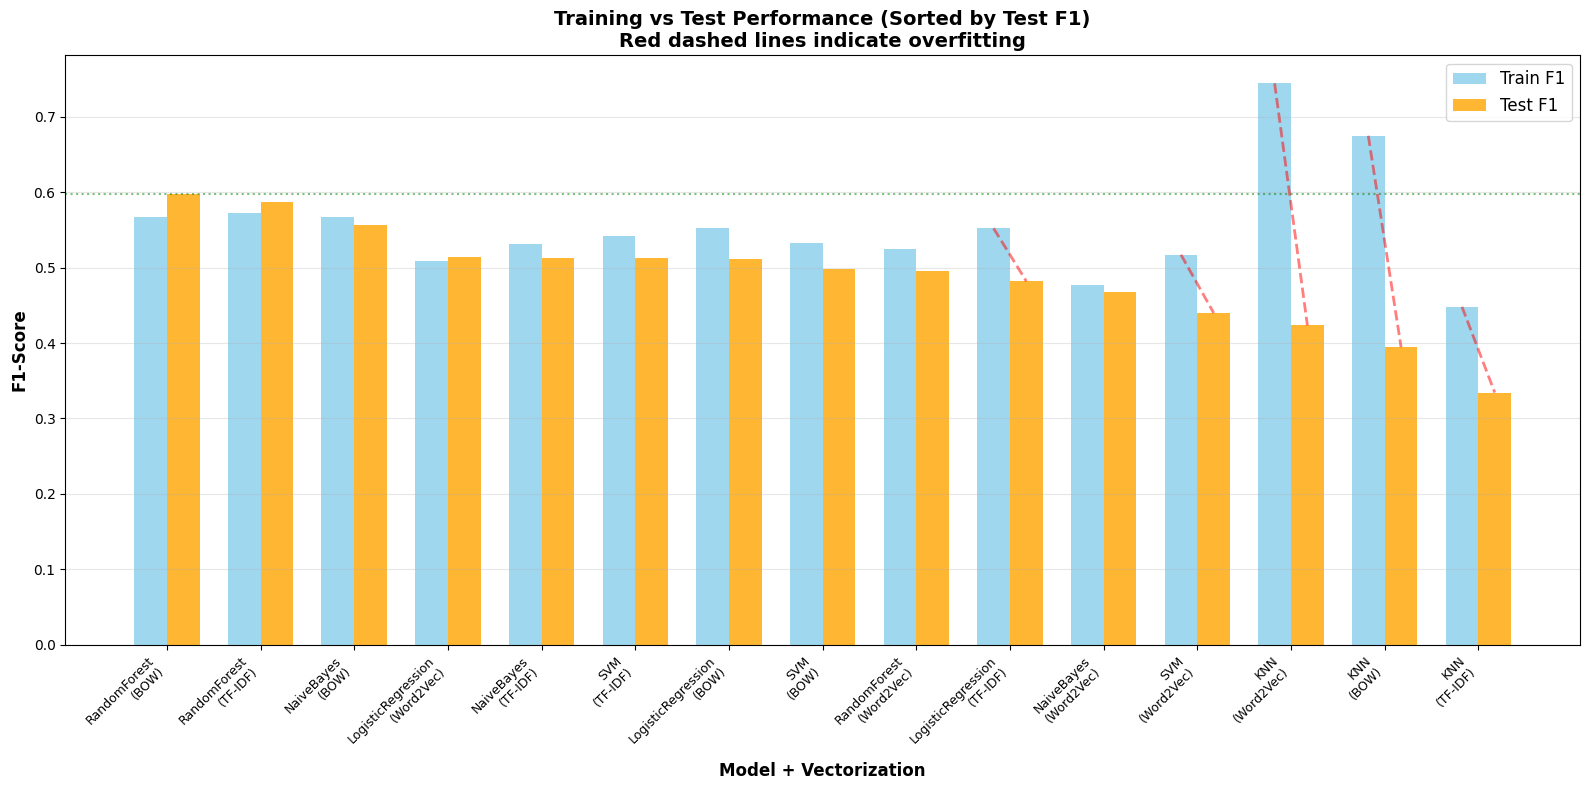

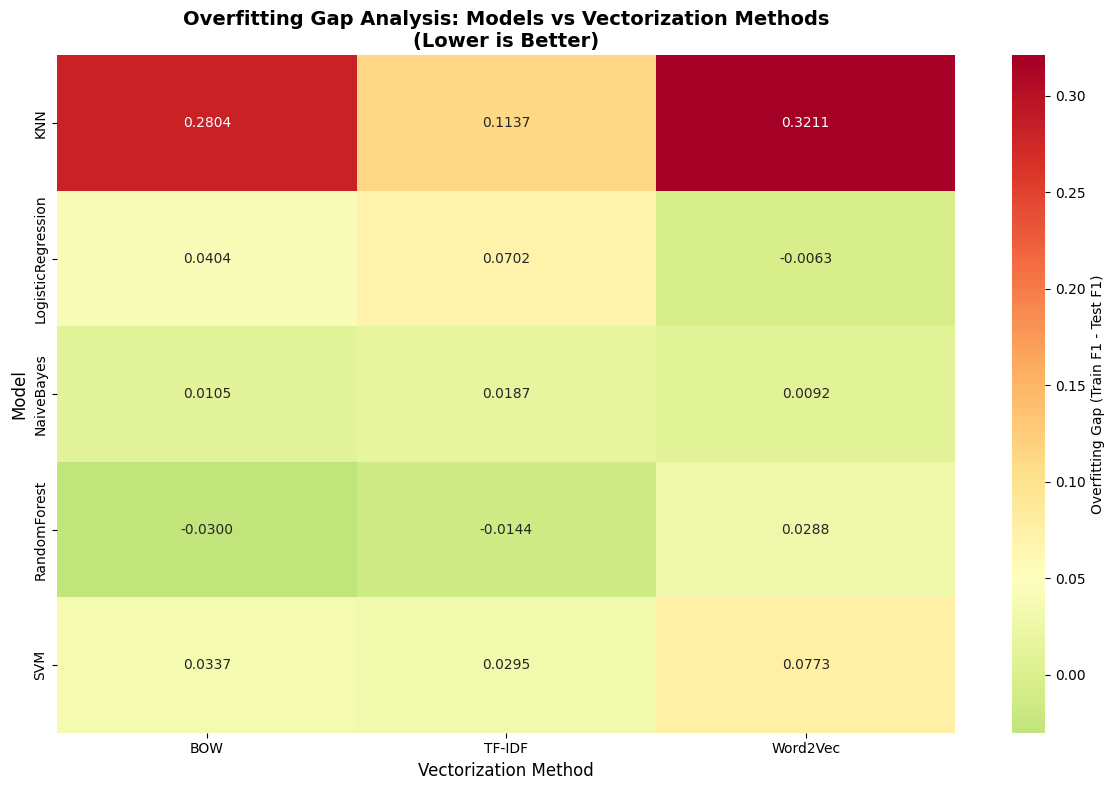

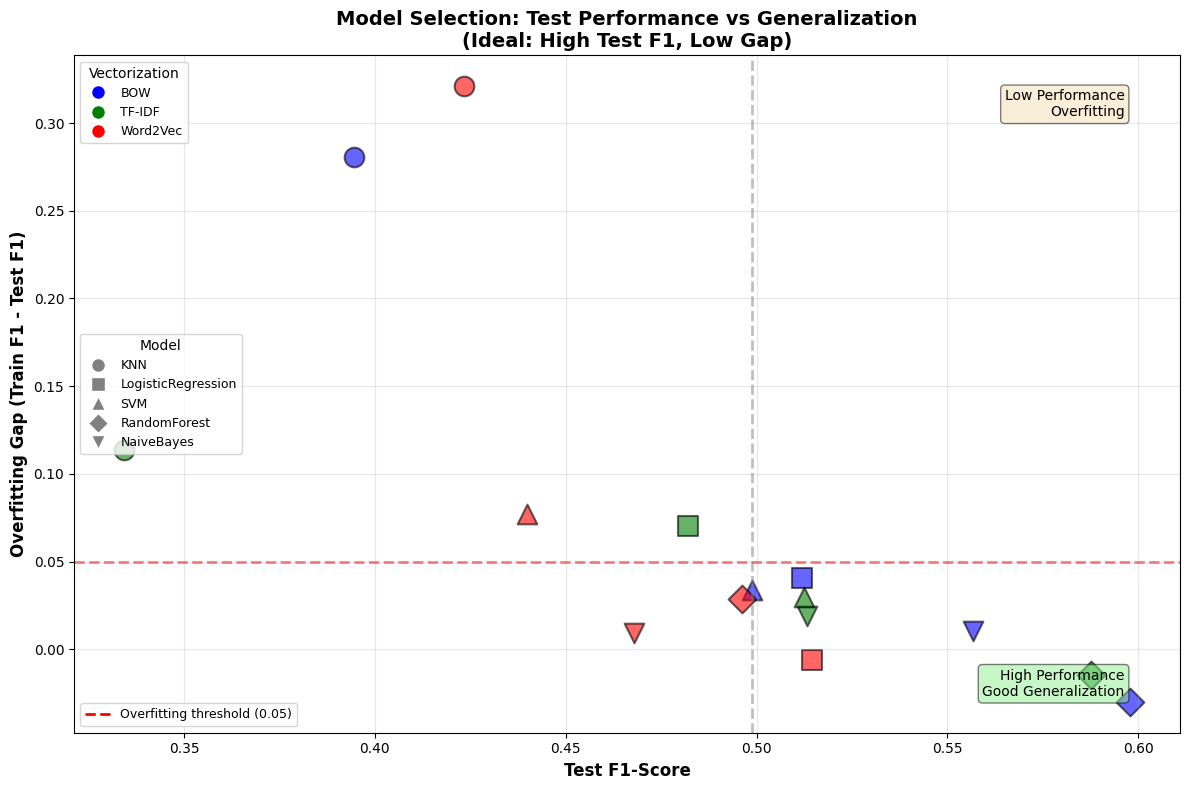

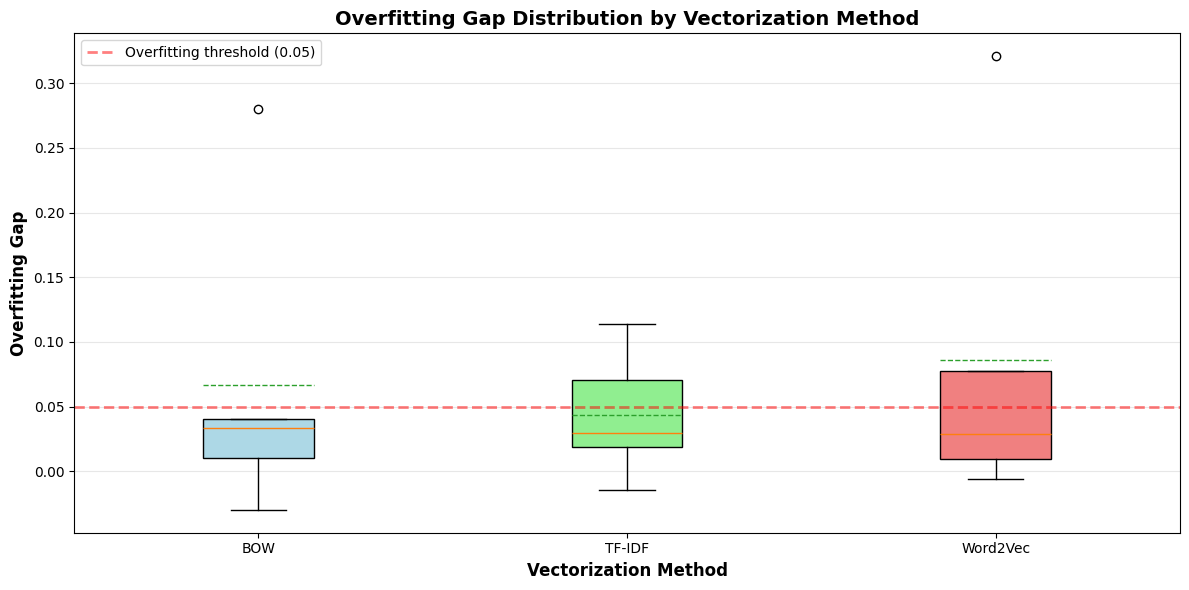

TRAIN-TEST GAP ANALYSIS COMPLETE
TRAIN-TEST GAP ANALYSIS COMPLETE


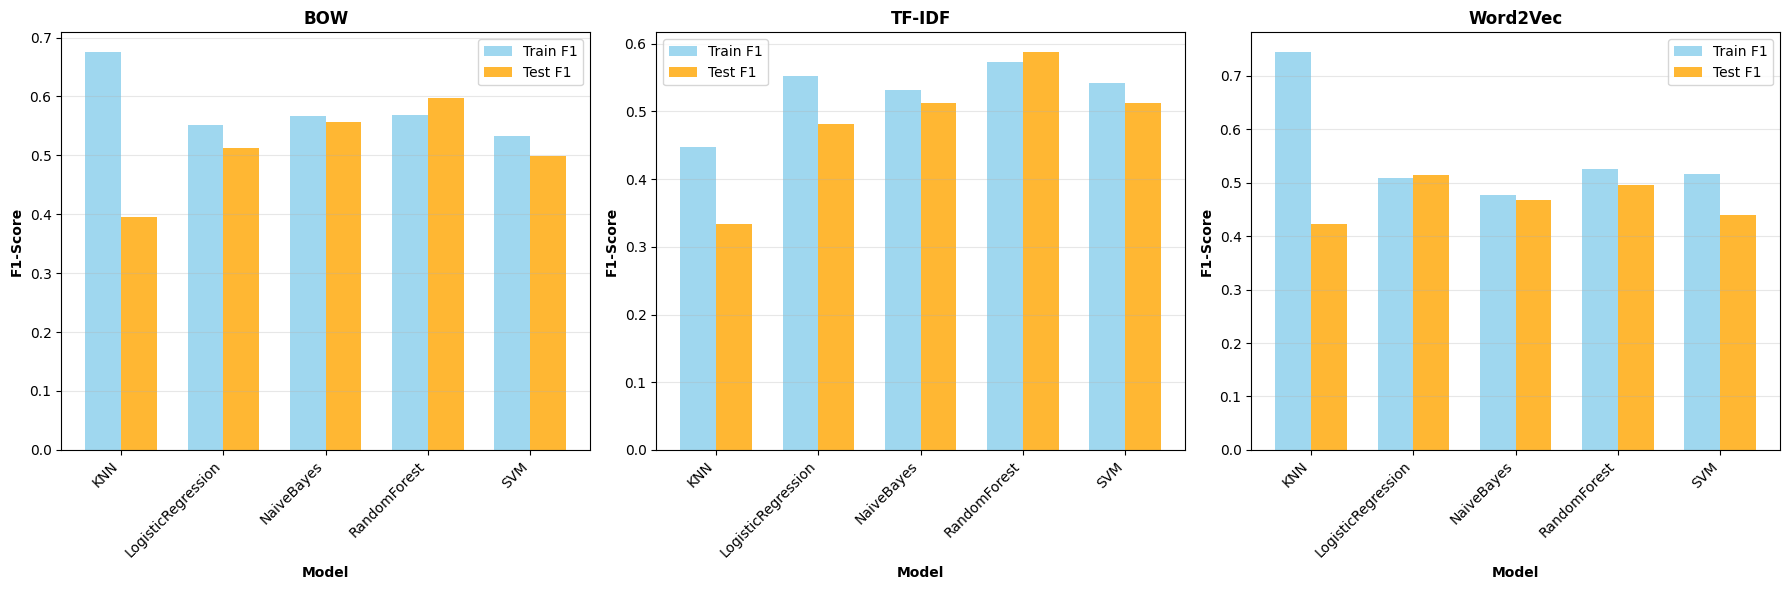

In [35]:
# Create comprehensive summary with train-test gap analysis
gap_data = []

for model_name, vectorizations in results.items():
    for vec_name, scores in vectorizations.items():
        gap_data.append({
            'Model': model_name,
            'Vectorization': vec_name,
            'Train_F1': scores['Train_F1'],
            'Test_F1': scores['Test_F1'],
            'Train_Precision': scores['Train_Precision'],
            'Test_Precision': scores['Test_Precision'],
            'Train_Recall': scores['Train_Recall'],
            'Test_Recall': scores['Test_Recall'],
            'Train_Accuracy': scores['Train_Accuracy'],
            'Test_Accuracy': scores['Test_Accuracy'],})

gap_df = pd.DataFrame(gap_data)
gap_df['Overfitting_Gap'] = gap_df['Train_F1'] - gap_df['Test_F1']
gap_df = gap_df.sort_values(['Test_F1', 'Overfitting_Gap'], ascending=[False, True])
print("COMPREHENSIVE PERFORMANCE ANALYSIS - SORTED BY TEST F1")

print("\nAll Metrics Summary:")
print(gap_df.to_string(index=False))
print("\n")

# Display key metrics in a cleaner format

print("KEY METRICS COMPARISON")
print("TRAIN-TEST PERFORMANCE ANALYSIS - SORTED BY TEST F1")
key_metrics_df = gap_df[['Model', 'Vectorization', 'Test_F1', 'Test_Precision',
                          'Test_Recall', 'Test_Accuracy', 'Overfitting_Gap']]
print(key_metrics_df.to_string(index=False))
print("\n")

# Identify best model
best_model_row = gap_df.iloc[0]
print("="*80)
print("BEST MODEL (Based on Test F1 and Generalization)")
print("="*80)
print(f"Model: {best_model_row['Model']}")
print(f"Vectorization: {best_model_row['Vectorization']}")
print(f"Training F1: {best_model_row['Train_F1']:.4f}")
print(f"Test F1: {best_model_row['Test_F1']:.4f}")
print(f"Overfitting Gap: {best_model_row['Overfitting_Gap']:.4f}")

# Identify models with overfitting issues
# Identify models with overfitting issues
print("="*80)
print("OVERFITTING ANALYSIS")
print("="*80)
overfitting_threshold = 0.05
overfitting_models = gap_df[gap_df['Overfitting_Gap'] > overfitting_threshold].sort_values('Overfitting_Gap', ascending=False)
print(f"Models with significant overfitting (gap > {overfitting_threshold}):")
print(overfitting_models[['Model', 'Vectorization', 'Train_F1', 'Test_F1', 'Overfitting_Gap']].to_string(index=False))
print("\n")

# Identify models with good generalization
good_generalization = gap_df[gap_df['Overfitting_Gap'] <= overfitting_threshold].sort_values('Test_F1', ascending=False)
print(f"Models with good generalization (gap ≤ {overfitting_threshold}):")
print(good_generalization[['Model', 'Vectorization', 'Train_F1', 'Test_F1', 'Overfitting_Gap']].to_string(index=False))
print("\n")

# Visualization 1: Train vs Test F1 Comparison
fig, ax = plt.subplots(figsize=(16, 8))
x = np.arange(len(gap_df))
width = 0.35

bars1 = ax.bar(x - width/2, gap_df['Train_F1'], width, label='Train F1', alpha=0.8, color='skyblue')
bars2 = ax.bar(x + width/2, gap_df['Test_F1'], width, label='Test F1', alpha=0.8, color='orange')

# Add gap indicators
for i, (train, test) in enumerate(zip(gap_df['Train_F1'], gap_df['Test_F1'])):
    gap = train - test
    if gap > overfitting_threshold:
        ax.plot([i - width/2, i + width/2], [train, test], 'r--', alpha=0.5, linewidth=2)

ax.set_xlabel('Model + Vectorization', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_title('Training vs Test Performance (Sorted by Test F1)\nRed dashed lines indicate overfitting',
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(
    gap_df['Model'] + '\n(' + gap_df['Vectorization'] + ')',
    rotation=45,
    ha='right',
    fontsize=9
)
ax.legend(fontsize=12)
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=best_model_row['Test_F1'], color='green', linestyle=':', alpha=0.5, label='Best Test F1')
plt.tight_layout()
plt.show()

# Visualization 2: Overfitting Gap Heatmap
fig, ax = plt.subplots(figsize=(12, 8))
pivot_gap = gap_df.pivot(index='Model', columns='Vectorization', values='Overfitting_Gap')
pivot_gap = gap_df.pivot(index='Model', columns='Vectorization', values='Overfitting_Gap')
sns.heatmap(pivot_gap, annot=True, fmt='.4f', cmap='RdYlGn_r', center=0.05,
            ax=ax, cbar_kws={'label': 'Overfitting Gap (Train F1 - Test F1)'})
ax.set_title('Overfitting Gap Analysis: Models vs Vectorization Methods\n(Lower is Better)',
            fontsize=14, fontweight='bold')
ax.set_xlabel('Vectorization Method', fontsize=12)
ax.set_ylabel('Model', fontsize=12)
plt.tight_layout()
plt.show()

# Visualization 3: Scatter Plot - Test F1 vs Overfitting Gap
fig, ax = plt.subplots(figsize=(12, 8))
colors_map = {'BOW': 'blue', 'TF-IDF': 'green', 'Word2Vec': 'red'}
colors_map = {'BOW': 'blue', 'TF-IDF': 'green', 'Word2Vec': 'red'}
markers_map = {'KNN': 'o', 'LogisticRegression': 's', 'SVM': '^',
               'RandomForest': 'D', 'NaiveBayes': 'v'}

for _, row in gap_df.iterrows():
    ax.scatter(row['Test_F1'], row['Overfitting_Gap'],
              c=colors_map[row['Vectorization']],
              marker=markers_map[row['Model']],
              s=200, alpha=0.6, edgecolors='black', linewidth=1.5)

# Add quadrant lines
ax.axhline(y=overfitting_threshold, color='red', linestyle='--', alpha=0.5, linewidth=2,
           label=f'Overfitting threshold ({overfitting_threshold})')
ax.axvline(x=gap_df['Test_F1'].median(), color='gray', linestyle='--', alpha=0.5, linewidth=2,
           label=f'Median Test F1 ({gap_df["Test_F1"].median():.3f})')

# Annotations for quadrants
ax.text(0.95, 0.95, 'Low Performance\nOverfitting', transform=ax.transAxes,
        fontsize=10, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.text(0.95, 0.05, 'High Performance\nGood Generalization', transform=ax.transAxes,
        fontsize=10, verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

from matplotlib.lines import Line2D
legend_vectorization = [Line2D([0], [0], marker='o', color='w',
                              markerfacecolor=color, markersize=10, label=vec)
                       for vec, color in colors_map.items()]
legend_models = [Line2D([0], [0], marker=marker, color='w',
                       markerfacecolor='gray', markersize=10, label=model)
                for model, marker in markers_map.items()]

first_legend = ax.legend(handles=legend_vectorization, loc='upper left',
                        title='Vectorization', fontsize=9)
ax.add_artist(first_legend)
second_legend = ax.legend(handles=legend_models, loc='center left', title='Model', fontsize=9)
ax.add_artist(second_legend)

# Add threshold line to legend
ax.plot([], [], 'r--', alpha=0.5, linewidth=2, label=f'Overfitting threshold ({overfitting_threshold})')
ax.legend(handles=[Line2D([0], [0], color='r', linestyle='--', linewidth=2)],
         labels=[f'Overfitting threshold ({overfitting_threshold})'],
         loc='lower left', fontsize=9)

ax.set_xlabel('Test F1-Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Overfitting Gap (Train F1 - Test F1)', fontsize=12, fontweight='bold')
ax.set_title('Model Selection: Test Performance vs Generalization\n(Ideal: High Test F1, Low Gap)',
            fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# Visualization 4: Box Plot - Overfitting Gap Distribution by Vectorization
# Visualization 4: Box Plot - Overfitting Gap Distribution by Vectorization
fig, ax = plt.subplots(figsize=(12, 6))

vectorization_order = ['BOW', 'TF-IDF', 'Word2Vec']
data_to_plot = [gap_df[gap_df['Vectorization'] == vec]['Overfitting_Gap'].values
                for vec in vectorization_order]
bp = ax.boxplot(data_to_plot, tick_labels=vectorization_order,
                patch_artist=True, showmeans=True, meanline=True)

colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.axhline(y=overfitting_threshold, color='red', linestyle='--', alpha=0.5, linewidth=2,
           label=f'Overfitting threshold ({overfitting_threshold})')

ax.set_ylabel('Overfitting Gap', fontsize=12, fontweight='bold')
ax.set_xlabel('Vectorization Method', fontsize=12, fontweight='bold')
ax.set_title('Overfitting Gap Distribution by Vectorization Method', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Visualization 5: Model Comparison - Average Train vs Test by Vectorization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, vec in enumerate(vectorization_order):
    ax = axes[idx]
    vec_data = gap_df[gap_df['Vectorization'] == vec].sort_values('Model')

    x_pos = np.arange(len(vec_data))
    width = 0.35

    ax.bar(x_pos - width/2, vec_data['Train_F1'], width, label='Train F1', alpha=0.8, color='skyblue')
    ax.bar(x_pos + width/2, vec_data['Test_F1'], width, label='Test F1', alpha=0.8, color='orange')

    ax.set_xlabel('Model', fontsize=10, fontweight='bold')
    ax.set_ylabel('F1-Score', fontsize=10, fontweight='bold')
    ax.set_title(f'{vec}', fontsize=12, fontweight='bold')
    ax.set_xticks(x_pos)

    ax.set_xticklabels(vec_data['Model'], rotation=45, ha='right')
    ax.legend()
    print("="*80)

    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    print("="*80)

    ax.grid(axis='y', alpha=0.3)
print("TRAIN-TEST GAP ANALYSIS COMPLETE")


plt.tight_layout()
print("TRAIN-TEST GAP ANALYSIS COMPLETE")

plt.tight_layout()
plt.show()
print("="*80)

plt.show()
print("="*80)


MODEL PERFORMANCE SUMMARY - SORTED BY TEST F1
             Model Vectorization  Train_F1  Test_F1  Train_Accuracy  Test_Accuracy  Train_Precision  Test_Precision  Train_Recall  Test_Recall  Overfitting_Gap
      RandomForest           BOW  0.567736 0.597778        0.725707       0.781429         0.598450        0.590695      0.564586     0.610000        -0.030042
      RandomForest        TF-IDF  0.573164 0.587586        0.701188       0.743571         0.581678        0.580905      0.569755     0.621250        -0.014422
        NaiveBayes           BOW  0.567159 0.556667        0.679841       0.782857         0.568361        0.556667      0.566653     0.556667         0.010492
LogisticRegression      Word2Vec  0.508305 0.514570        0.569086       0.655000         0.519940        0.529813      0.525897     0.552917        -0.006265
        NaiveBayes        TF-IDF  0.531938 0.513216        0.714165       0.821429         0.561682        0.535397      0.536507     0.516667         0.0

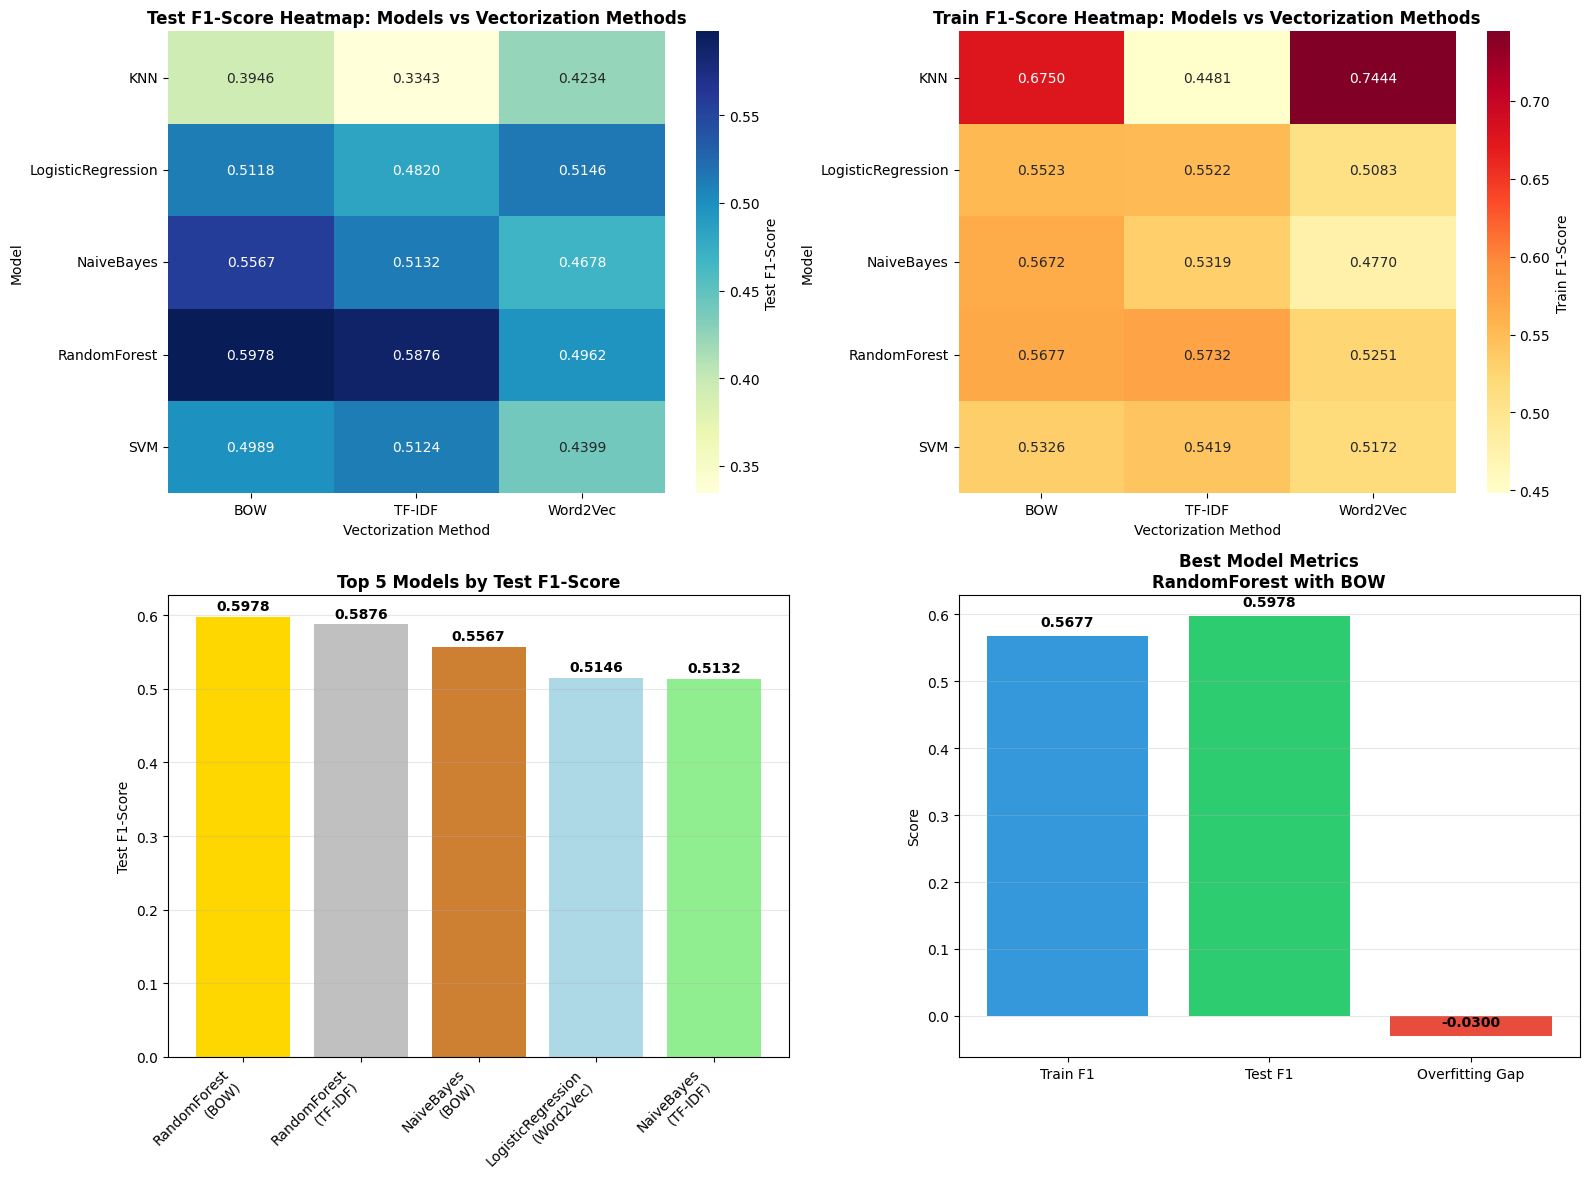

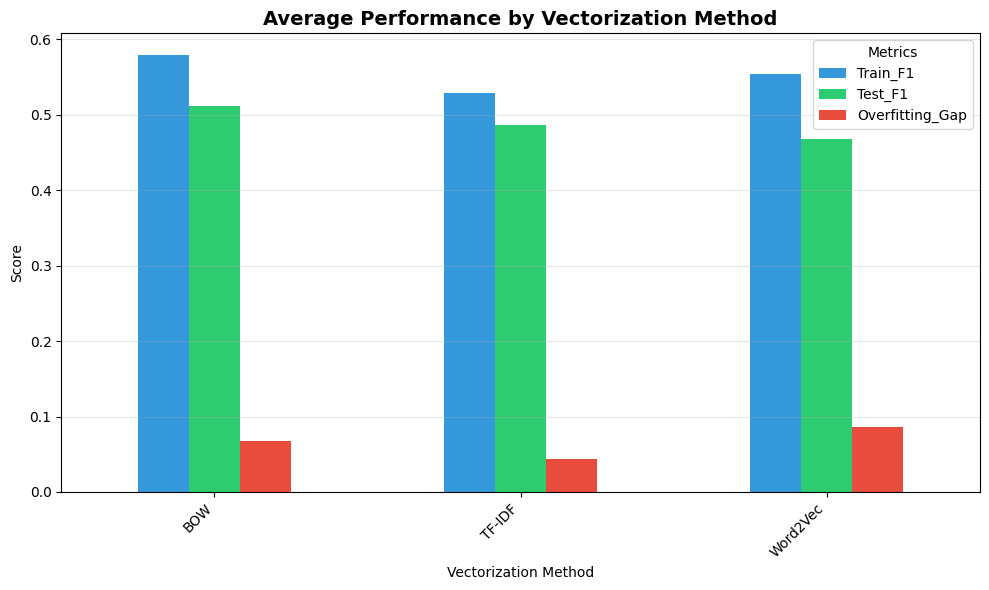

SUMMARY COMPLETE


In [36]:
# Create comprehensive summary using the results dictionary
summary_data = []

for model_name, vectorizations in results.items():
    for vec_name, scores in vectorizations.items():
        summary_data.append({
            'Model': model_name,
            'Vectorization': vec_name,
            'Train_F1': scores['Train_F1'],
            'Test_F1': scores['Test_F1'],
            'Train_Accuracy': scores['Train_Accuracy'],
            'Test_Accuracy': scores['Test_Accuracy'],
            'Train_Precision': scores['Train_Precision'],
            'Test_Precision': scores['Test_Precision'],
            'Train_Recall': scores['Train_Recall'],
            'Test_Recall': scores['Test_Recall'],
            'Overfitting_Gap': scores['Train_F1'] - scores['Test_F1']
        })

summary_df = pd.DataFrame(summary_data)

# Sort by Test F1-Score (descending) and Overfitting Gap (ascending)
summary_df = summary_df.sort_values(['Test_F1', 'Overfitting_Gap'], ascending=[False, True])

print("="*80)
print("MODEL PERFORMANCE SUMMARY - SORTED BY TEST F1")
print("="*80)
print(summary_df.to_string(index=False))
print("\n")

# Best model identification
best_model = summary_df.iloc[0]
print("="*80)
print("BEST PERFORMING MODEL")
print("="*80)
print(f"Model: {best_model['Model']}")
print(f"Vectorization Method: {best_model['Vectorization']}")
print(f"Training F1-Score: {best_model['Train_F1']:.4f}")
print(f"Test F1-Score: {best_model['Test_F1']:.4f}")
print(f"Overfitting Gap: {best_model['Overfitting_Gap']:.4f}")
print("\n")

# Vectorization comparison
print("="*80)
print("VECTORIZATION METHOD COMPARISON (AVERAGE ACROSS ALL MODELS)")
print("="*80)
vectorization_comparison = summary_df.groupby('Vectorization')[['Train_F1', 'Test_F1', 'Overfitting_Gap']].mean()
print(vectorization_comparison)
print("\n")

best_vectorization = vectorization_comparison['Test_F1'].idxmax()
print(f"Best Vectorization Method: {best_vectorization}")
print(f"Average Test F1: {vectorization_comparison.loc[best_vectorization, 'Test_F1']:.4f}")
print(f"Average Overfitting Gap: {vectorization_comparison.loc[best_vectorization, 'Overfitting_Gap']:.4f}")
print("\n")

# Model comparison
print("="*80)
print("MODEL COMPARISON (AVERAGE ACROSS ALL VECTORIZATION METHODS)")
print("="*80)
model_comparison = summary_df.groupby('Model')[['Train_F1', 'Test_F1', 'Overfitting_Gap']].mean()
model_comparison = model_comparison.sort_values('Test_F1', ascending=False)
print(model_comparison)
print("\n")

best_model_type = model_comparison['Test_F1'].idxmax()
print(f"Best Model Type: {best_model_type}")
print(f"Average Test F1: {model_comparison.loc[best_model_type, 'Test_F1']:.4f}")
print(f"Average Overfitting Gap: {model_comparison.loc[best_model_type, 'Overfitting_Gap']:.4f}")
print("\n")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Test F1-Score Heatmap
pivot_test_f1 = summary_df.pivot(index='Model', columns='Vectorization', values='Test_F1')
sns.heatmap(pivot_test_f1, annot=True, fmt='.4f', cmap='YlGnBu', ax=axes[0, 0],
            cbar_kws={'label': 'Test F1-Score'})
axes[0, 0].set_title('Test F1-Score Heatmap: Models vs Vectorization Methods',
                     fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Vectorization Method')
axes[0, 0].set_ylabel('Model')

# 2. Train F1-Score Heatmap
pivot_train_f1 = summary_df.pivot(index='Model', columns='Vectorization', values='Train_F1')
sns.heatmap(pivot_train_f1, annot=True, fmt='.4f', cmap='YlOrRd', ax=axes[0, 1],
            cbar_kws={'label': 'Train F1-Score'})
axes[0, 1].set_title('Train F1-Score Heatmap: Models vs Vectorization Methods',
                     fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Vectorization Method')
axes[0, 1].set_ylabel('Model')

# 3. Top 5 Models by Test F1
top_5 = summary_df.head(5).copy()
top_5['Model_Vec'] = top_5['Model'] + '\n(' + top_5['Vectorization'] + ')'
axes[1, 0].bar(range(len(top_5)), top_5['Test_F1'],
              color=['gold', 'silver', '#CD7F32', 'lightblue', 'lightgreen'])
axes[1, 0].set_xticks(range(len(top_5)))
axes[1, 0].set_xticklabels(top_5['Model_Vec'], rotation=45, ha='right')
axes[1, 0].set_ylabel('Test F1-Score')
axes[1, 0].set_title('Top 5 Models by Test F1-Score', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(top_5['Test_F1']):
    axes[1, 0].text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# 4. Best Model Metrics
best_metrics_values = [best_model['Train_F1'], best_model['Test_F1'], best_model['Overfitting_Gap']]
metric_names = ['Train F1', 'Test F1', 'Overfitting Gap']
colors_metrics = ['#3498db', '#2ecc71', '#e74c3c']
bars = axes[1, 1].bar(metric_names, best_metrics_values, color=colors_metrics)
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title(f'Best Model Metrics\n{best_model["Model"]} with {best_model["Vectorization"]}',
                      fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)
for bar, value in zip(bars, best_metrics_values):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Additional visualization - Vectorization comparison
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
vectorization_comparison.plot(kind='bar', ax=ax, color=['#3498db', '#2ecc71', '#e74c3c'])
ax.set_title('Average Performance by Vectorization Method', fontsize=14, fontweight='bold')
ax.set_xlabel('Vectorization Method')
ax.set_ylabel('Score')
ax.set_xticklabels(vectorization_comparison.index, rotation=45, ha='right')
ax.legend(title='Metrics')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("="*80)
print("SUMMARY COMPLETE")
print("="*80)

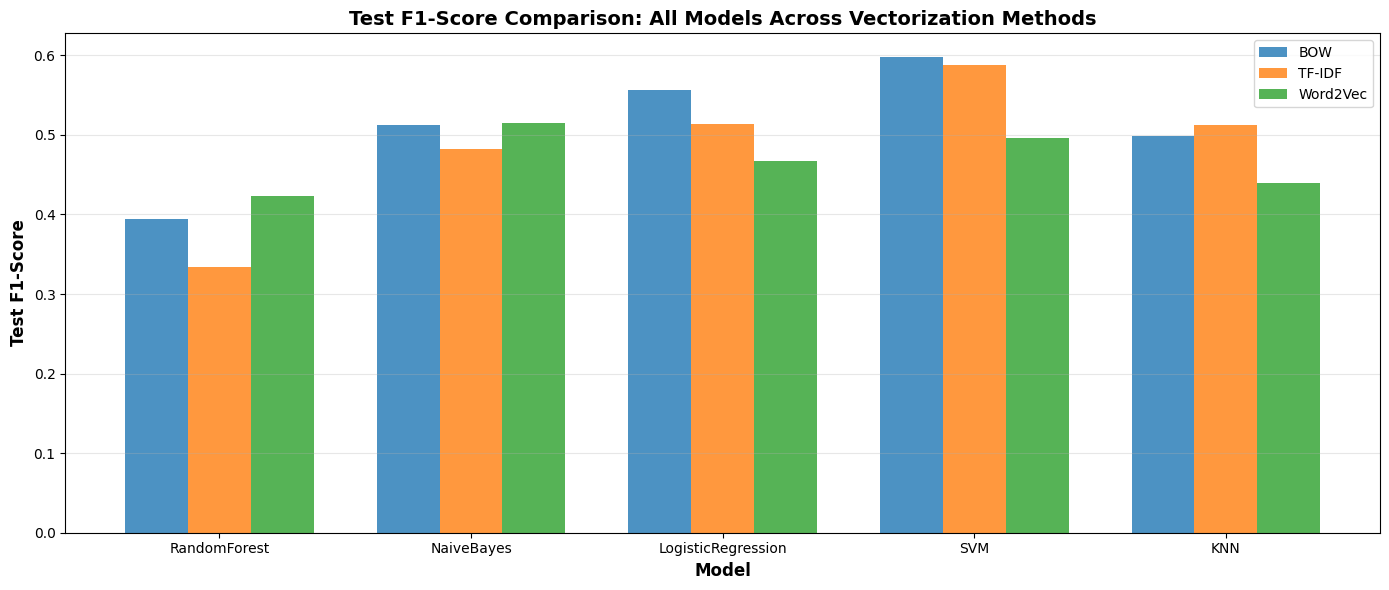

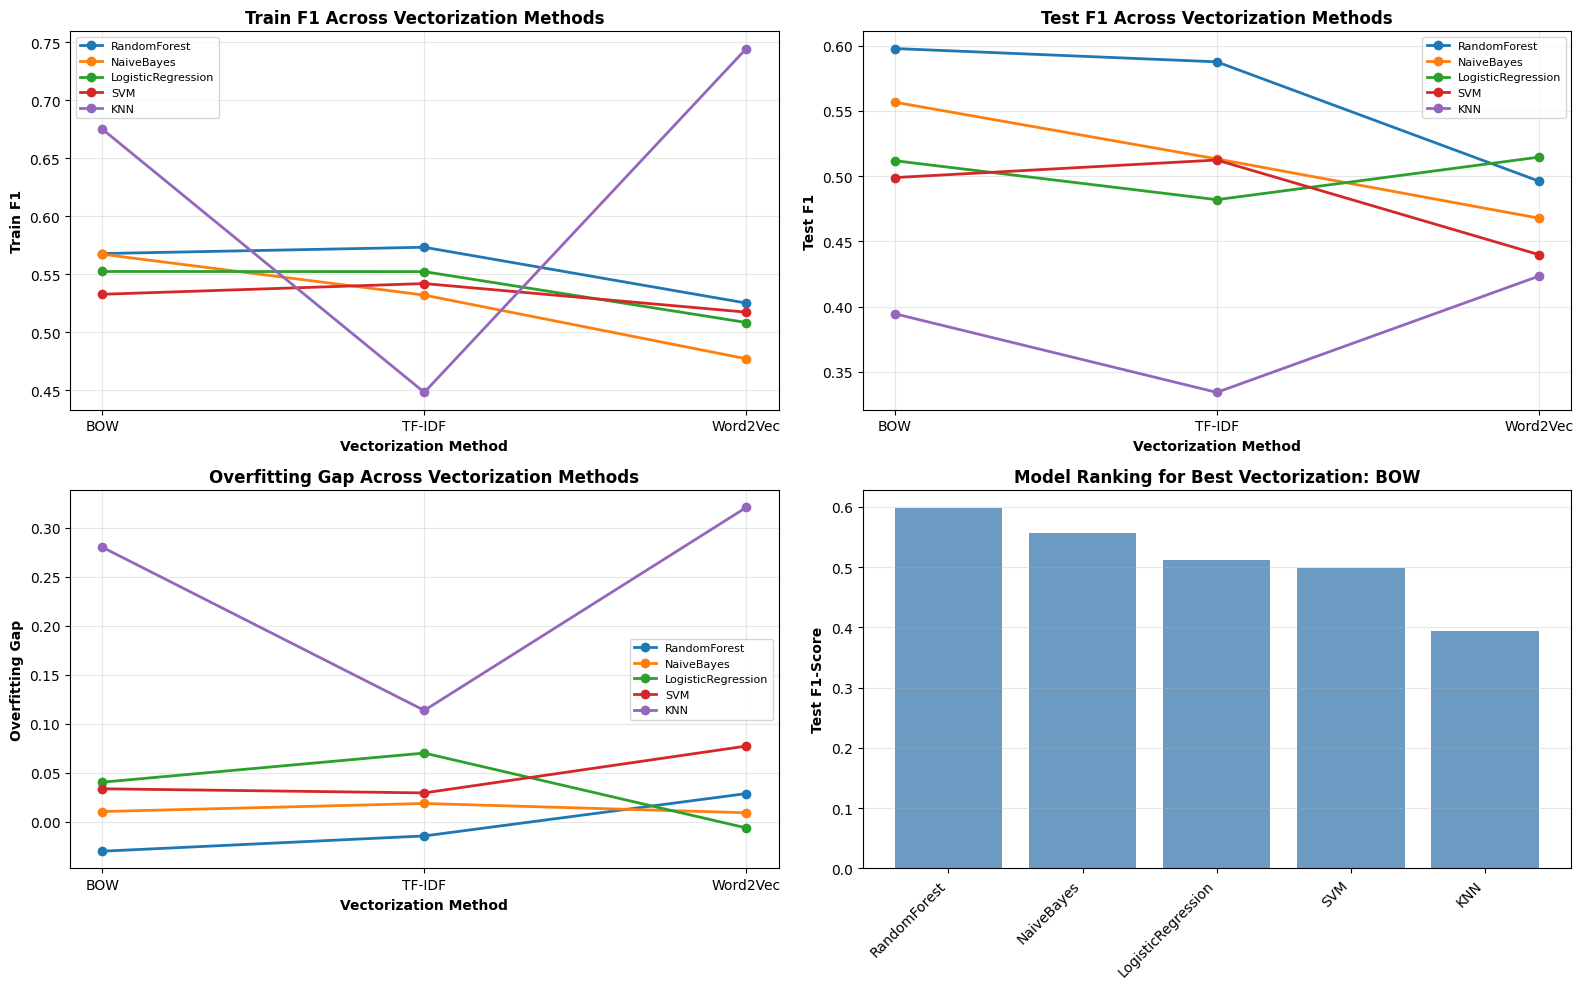

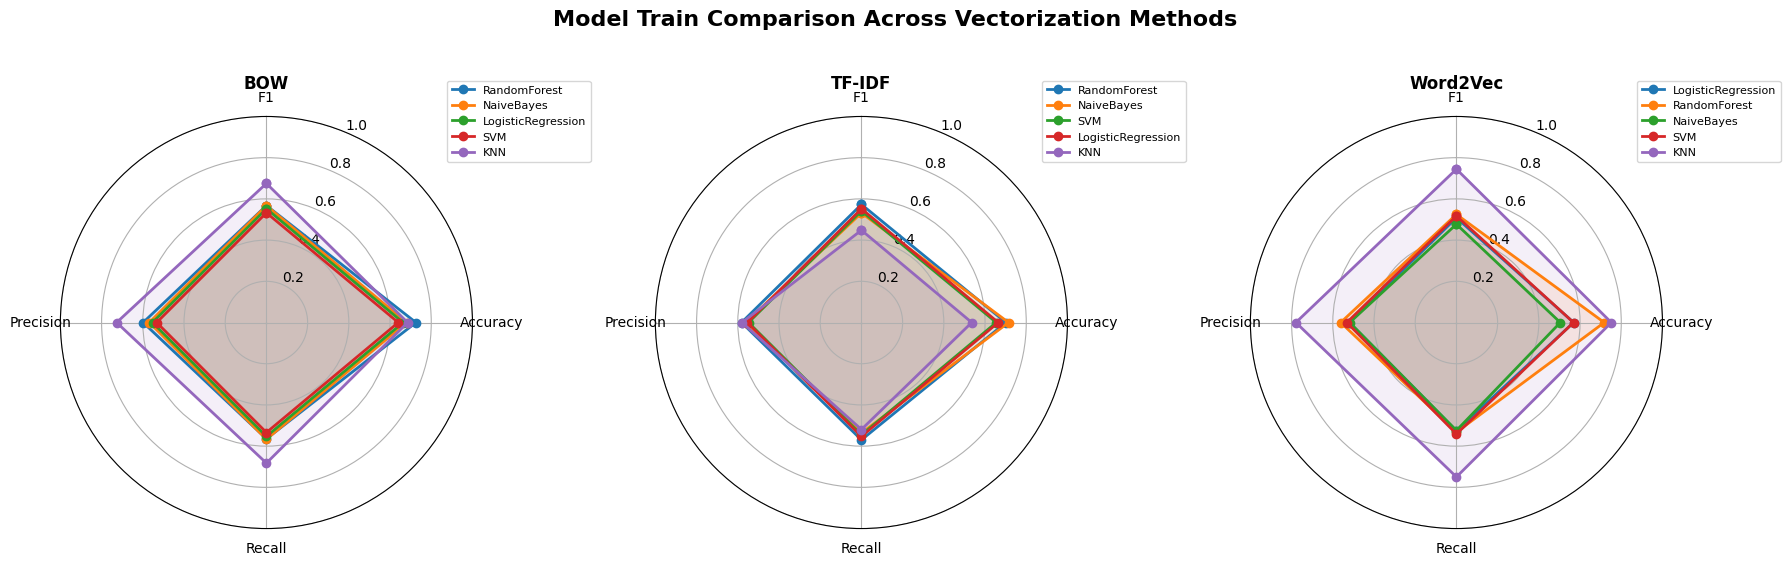

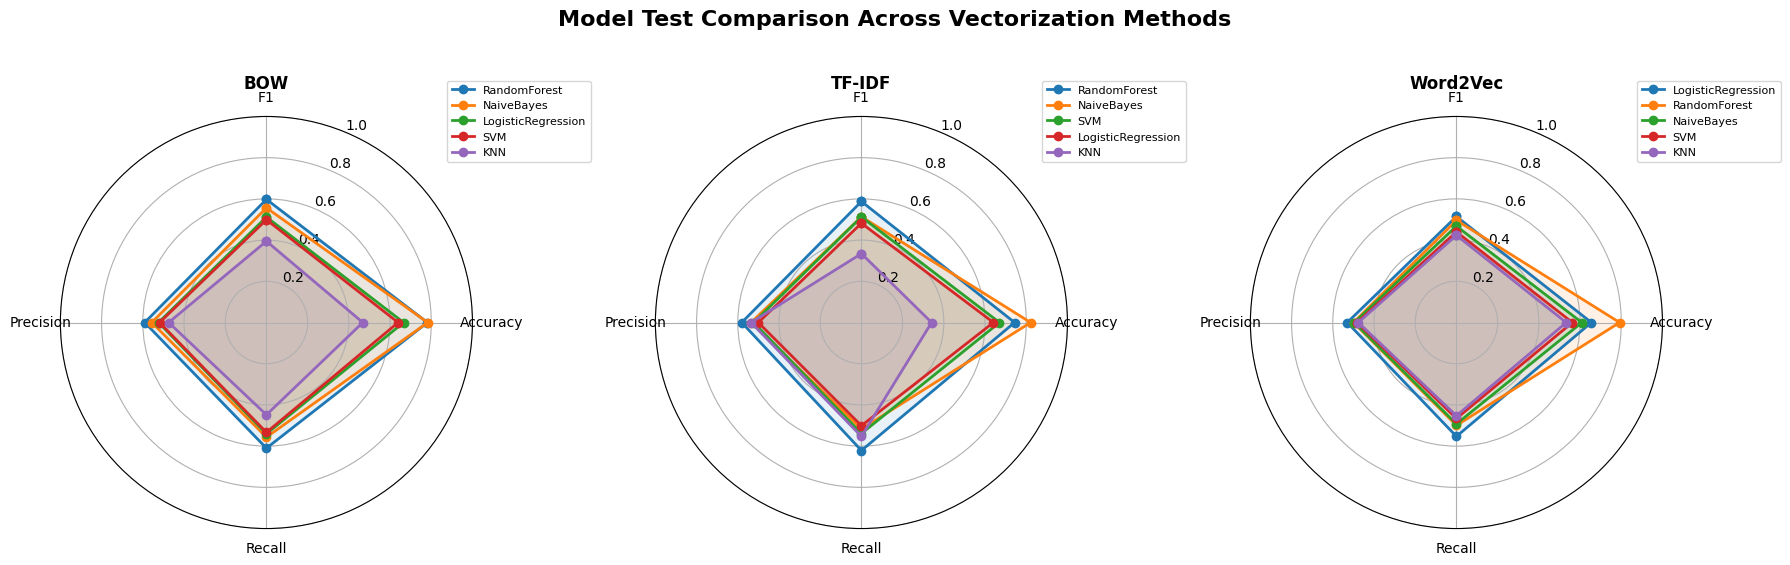

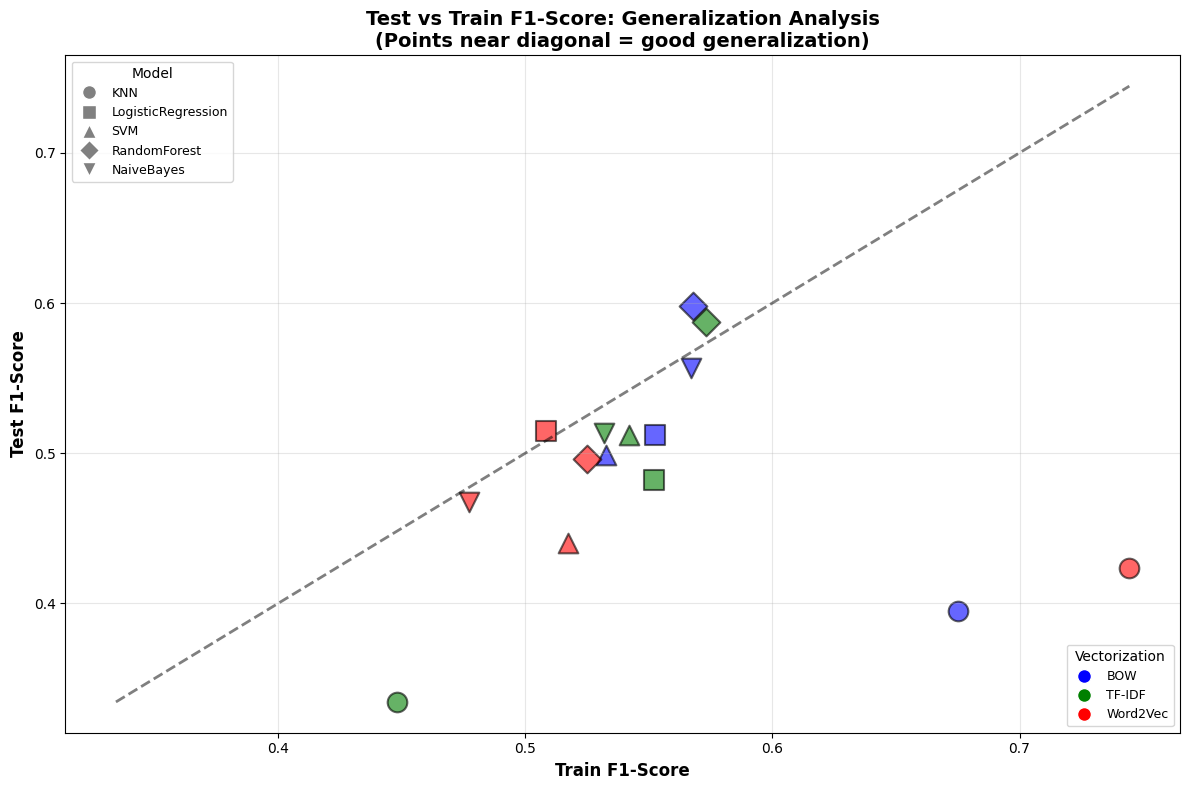

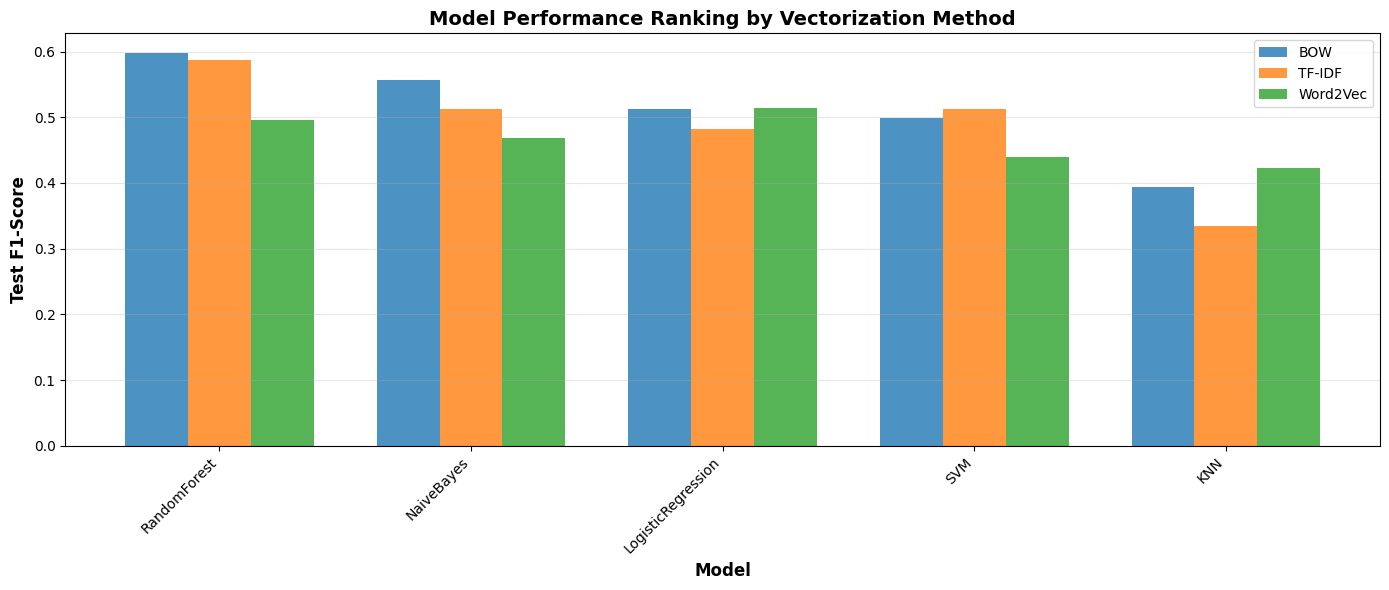

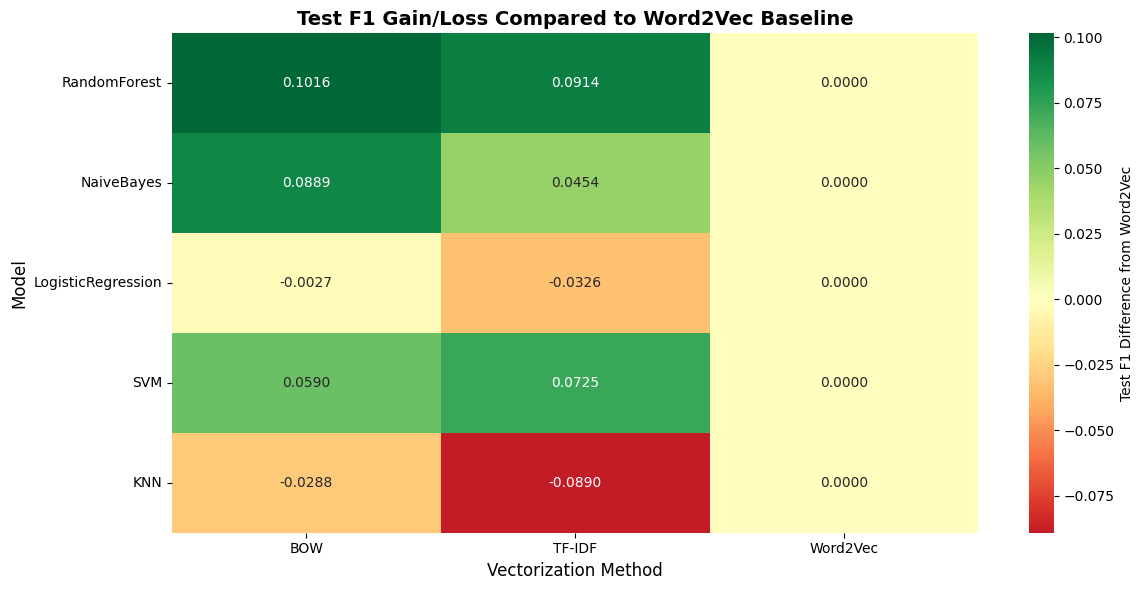

ADDITIONAL VISUALIZATIONS COMPLETE


In [37]:
# Additional Detailed Visualizations

# 1. Grouped Bar Chart - Test F1 by Model and Vectorization
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(summary_df['Model'].unique()))
width = 0.25

for i, vectorization in enumerate(['BOW', 'TF-IDF', 'Word2Vec']):
    vec_data = summary_df[summary_df['Vectorization'] == vectorization]
    vec_data = vec_data.sort_values('Model')
    ax.bar(x + i*width, vec_data['Test_F1'], width, label=vectorization, alpha=0.8)

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Test F1-Score', fontsize=12, fontweight='bold')
ax.set_title('Test F1-Score Comparison: All Models Across Vectorization Methods',
            fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(summary_df['Model'].unique())
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Line Plot - Model Performance Trends Across Vectorization Methods
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
metrics_to_plot = ['Train_F1', 'Test_F1', 'Overfitting_Gap']

for idx, metric in enumerate(metrics_to_plot):
    if idx < 3:
        ax = axes[idx // 2, idx % 2]

        for model in summary_df['Model'].unique():
            model_data = summary_df[summary_df['Model'] == model].sort_values('Vectorization')
            ax.plot(model_data['Vectorization'], model_data[metric], marker='o', label=model, linewidth=2)

        ax.set_xlabel('Vectorization Method', fontsize=10, fontweight='bold')
        ax.set_ylabel(metric.replace('_', ' '), fontsize=10, fontweight='bold')
        ax.set_title(f'{metric.replace("_", " ")} Across Vectorization Methods',
                    fontsize=12, fontweight='bold')
        ax.legend(loc='best', fontsize=8)
        ax.grid(True, alpha=0.3)

# 4th subplot: Comparison of metrics for best vectorization
ax = axes[1, 1]
best_vec_data = summary_df[summary_df['Vectorization'] == best_vectorization].sort_values('Test_F1', ascending=False)
x_pos = np.arange(len(best_vec_data))
ax.bar(x_pos, best_vec_data['Test_F1'], alpha=0.8, color='steelblue')
ax.set_xticks(x_pos)
ax.set_xticklabels(best_vec_data['Model'], rotation=45, ha='right')
ax.set_ylabel('Test F1-Score', fontsize=10, fontweight='bold')
ax.set_title(f'Model Ranking for Best Vectorization: {best_vectorization}',
            fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Radar Chart - Model Comparison for Each Vectorization
from math import pi

fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw=dict(projection='polar'))
categories = ['F1', 'Accuracy','Recall','Precision']
vectorizations = ['BOW', 'TF-IDF', 'Word2Vec']
fig.suptitle('Model Train Comparison Across Vectorization Methods', fontsize=16, fontweight='bold')
for idx, vectorization in enumerate(vectorizations):
    ax = axes[idx]
    vec_data = summary_df[summary_df['Vectorization'] == vectorization]

    angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
    angles += angles[:1]

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)

    for _, row in vec_data.iterrows():
        values = [row['Train_F1'],row['Train_Accuracy'],row['Train_Recall'],row['Train_Precision']]
        values += values[:1]
        ax.plot(angles, values, 'o-', linewidth=2, label=row['Model'])
        ax.fill(angles, values, alpha=0.1)

    ax.set_ylim(0, 1)
    ax.set_title(f'{vectorization}', fontsize=12, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=8)
    ax.grid(True)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw=dict(projection='polar'))
categories = ['F1', 'Accuracy','Recall','Precision']
vectorizations = ['BOW', 'TF-IDF', 'Word2Vec']
fig.suptitle('Model Test Comparison Across Vectorization Methods', fontsize=16, fontweight='bold')
for idx, vectorization in enumerate(vectorizations):
    ax = axes[idx]
    vec_data = summary_df[summary_df['Vectorization'] == vectorization]

    angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
    angles += angles[:1]

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)

    for _, row in vec_data.iterrows():
        values = [row['Test_F1'],row['Test_Accuracy'],row['Test_Recall'],row['Test_Precision']]
        values += values[:1]
        ax.plot(angles, values, 'o-', linewidth=2, label=row['Model'])
        ax.fill(angles, values, alpha=0.1)

    ax.set_ylim(0, 1)
    ax.set_title(f'{vectorization}', fontsize=12, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=8)
    ax.grid(True)

plt.tight_layout()
plt.show()

# 4. Scatter Plot - Test F1 vs Train F1 (Diagonal = Perfect Generalization)
fig, ax = plt.subplots(figsize=(12, 8))

colors_map = {'BOW': 'blue', 'TF-IDF': 'green', 'Word2Vec': 'red'}
markers_map = {'KNN': 'o', 'LogisticRegression': 's', 'SVM': '^',
               'RandomForest': 'D', 'NaiveBayes': 'v'}

for _, row in summary_df.iterrows():
    ax.scatter(row['Train_F1'], row['Test_F1'],
              c=colors_map[row['Vectorization']],
              marker=markers_map[row['Model']],
              s=200, alpha=0.6, edgecolors='black', linewidth=1.5)

# Add perfect generalization line (diagonal)
min_val = min(summary_df['Test_F1'].min(), summary_df['Train_F1'].min())
max_val = max(summary_df['Test_F1'].max(), summary_df['Train_F1'].max())
ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, linewidth=2,
       label='Perfect Generalization')

from matplotlib.lines import Line2D
legend_vectorization = [Line2D([0], [0], marker='o', color='w',
                              markerfacecolor=color, markersize=10, label=vec)
                       for vec, color in colors_map.items()]
legend_models = [Line2D([0], [0], marker=marker, color='w',
                       markerfacecolor='gray', markersize=10, label=model)
                for model, marker in markers_map.items()]

first_legend = ax.legend(handles=legend_vectorization, loc='lower right',
                        title='Vectorization', fontsize=9)
ax.add_artist(first_legend)
ax.legend(handles=legend_models, loc='upper left', title='Model', fontsize=9)

ax.set_xlabel('Train F1-Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Test F1-Score', fontsize=12, fontweight='bold')
ax.set_title('Test vs Train F1-Score: Generalization Analysis\n(Points near diagonal = good generalization)',
            fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Stacked Performance Breakdown
fig, ax = plt.subplots(figsize=(14, 6))

models_sorted = summary_df.groupby('Model')['Test_F1'].mean().sort_values(ascending=False).index
x_pos = np.arange(len(models_sorted))
width = 0.25

for i, vec in enumerate(['BOW', 'TF-IDF', 'Word2Vec']):
    vec_data = []
    for model in models_sorted:
        mask = (summary_df['Model'] == model) & (summary_df['Vectorization'] == vec)
        if mask.any():
            vec_data.append(summary_df[mask]['Test_F1'].values[0])
        else:
            vec_data.append(0)

    ax.bar(x_pos + i*width, vec_data, width, label=vec, alpha=0.8)

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Test F1-Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Ranking by Vectorization Method', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos + width)
ax.set_xticklabels(models_sorted, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 6. Difference Heatmap - Performance Gain/Loss from Word2Vec Baseline
fig, ax = plt.subplots(figsize=(12, 6))

diff_data = []
for model in summary_df['Model'].unique():
    model_data = summary_df[summary_df['Model'] == model]
    w2v_f1 = model_data[model_data['Vectorization'] == 'Word2Vec']['Test_F1'].values[0]

    row = []
    for vec in ['BOW', 'TF-IDF', 'Word2Vec']:
        vec_f1 = model_data[model_data['Vectorization'] == vec]['Test_F1'].values[0]
        row.append(vec_f1 - w2v_f1)
    diff_data.append(row)

sns.heatmap(diff_data, annot=True, fmt='.4f', cmap='RdYlGn', center=0,
            xticklabels=['BOW', 'TF-IDF', 'Word2Vec'],
            yticklabels=summary_df['Model'].unique(),
            ax=ax, cbar_kws={'label': 'Test F1 Difference from Word2Vec'})
ax.set_title('Test F1 Gain/Loss Compared to Word2Vec Baseline',
            fontsize=14, fontweight='bold')
ax.set_xlabel('Vectorization Method', fontsize=12)
ax.set_ylabel('Model', fontsize=12)
plt.tight_layout()
plt.show()

print("="*80)
print("ADDITIONAL VISUALIZATIONS COMPLETE")
print("="*80)

**Comprehensive Multi-Metric Analysis**

COMPREHENSIVE METRICS SUMMARY - ALL 15 CONFIGURATIONS

Test Set Performance (Primary Evaluation):
             Model Vectorization  Test_F1  Test_Precision  Test_Recall  Test_Accuracy
      RandomForest           BOW 0.597778        0.590695     0.610000       0.781429
      RandomForest        TF-IDF 0.587586        0.580905     0.621250       0.743571
        NaiveBayes           BOW 0.556667        0.556667     0.556667       0.782857
LogisticRegression      Word2Vec 0.514570        0.529813     0.552917       0.655000
        NaiveBayes        TF-IDF 0.513216        0.535397     0.516667       0.821429
               SVM        TF-IDF 0.512358        0.523112     0.538750       0.670000
LogisticRegression           BOW 0.511848        0.523763     0.540417       0.665714
               SVM           BOW 0.498908        0.518522     0.533333       0.639286
      RandomForest      Word2Vec 0.496210        0.499381     0.499583       0.792143
LogisticRegression        TF-IDF 0.481968 

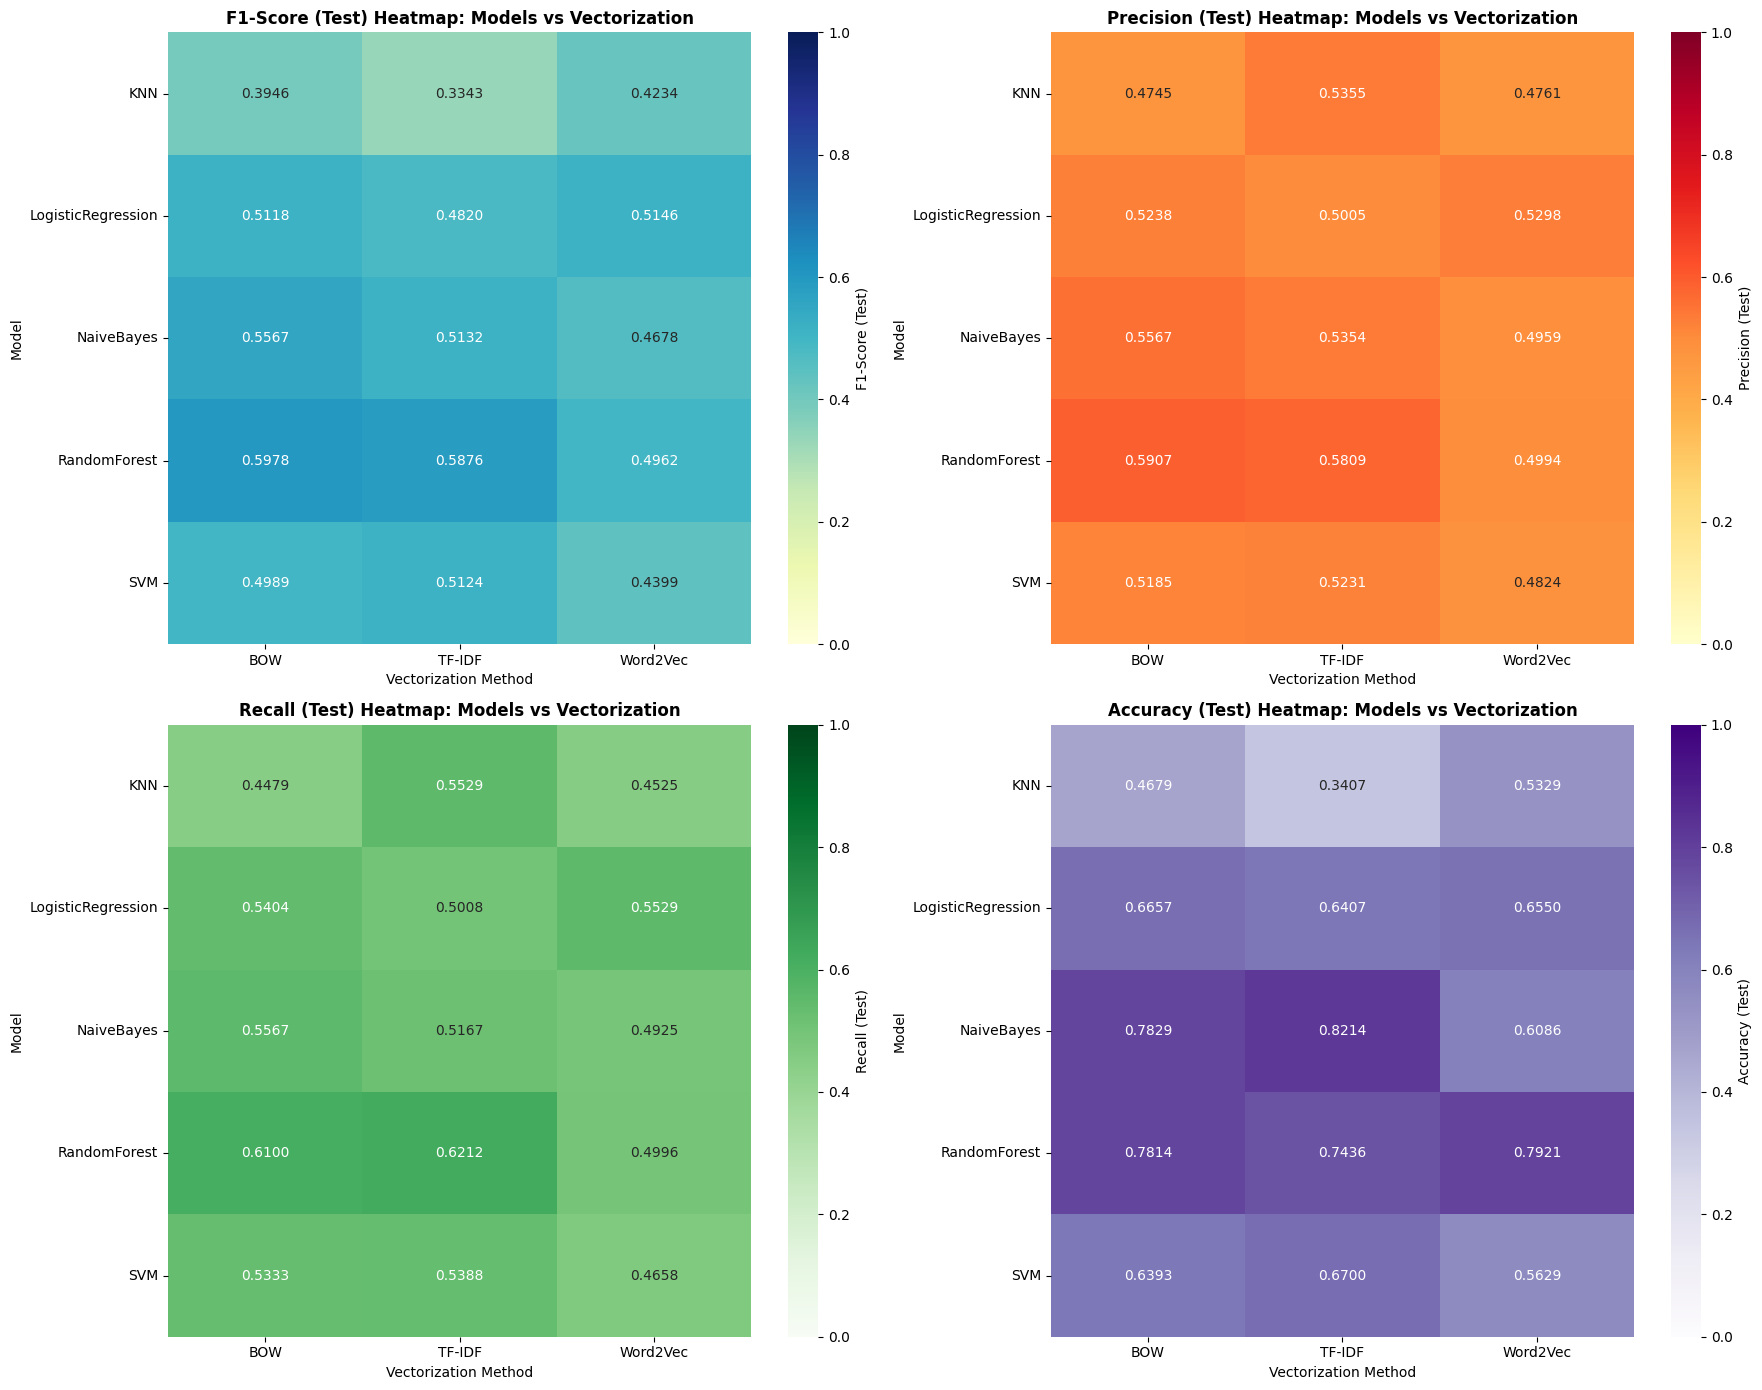

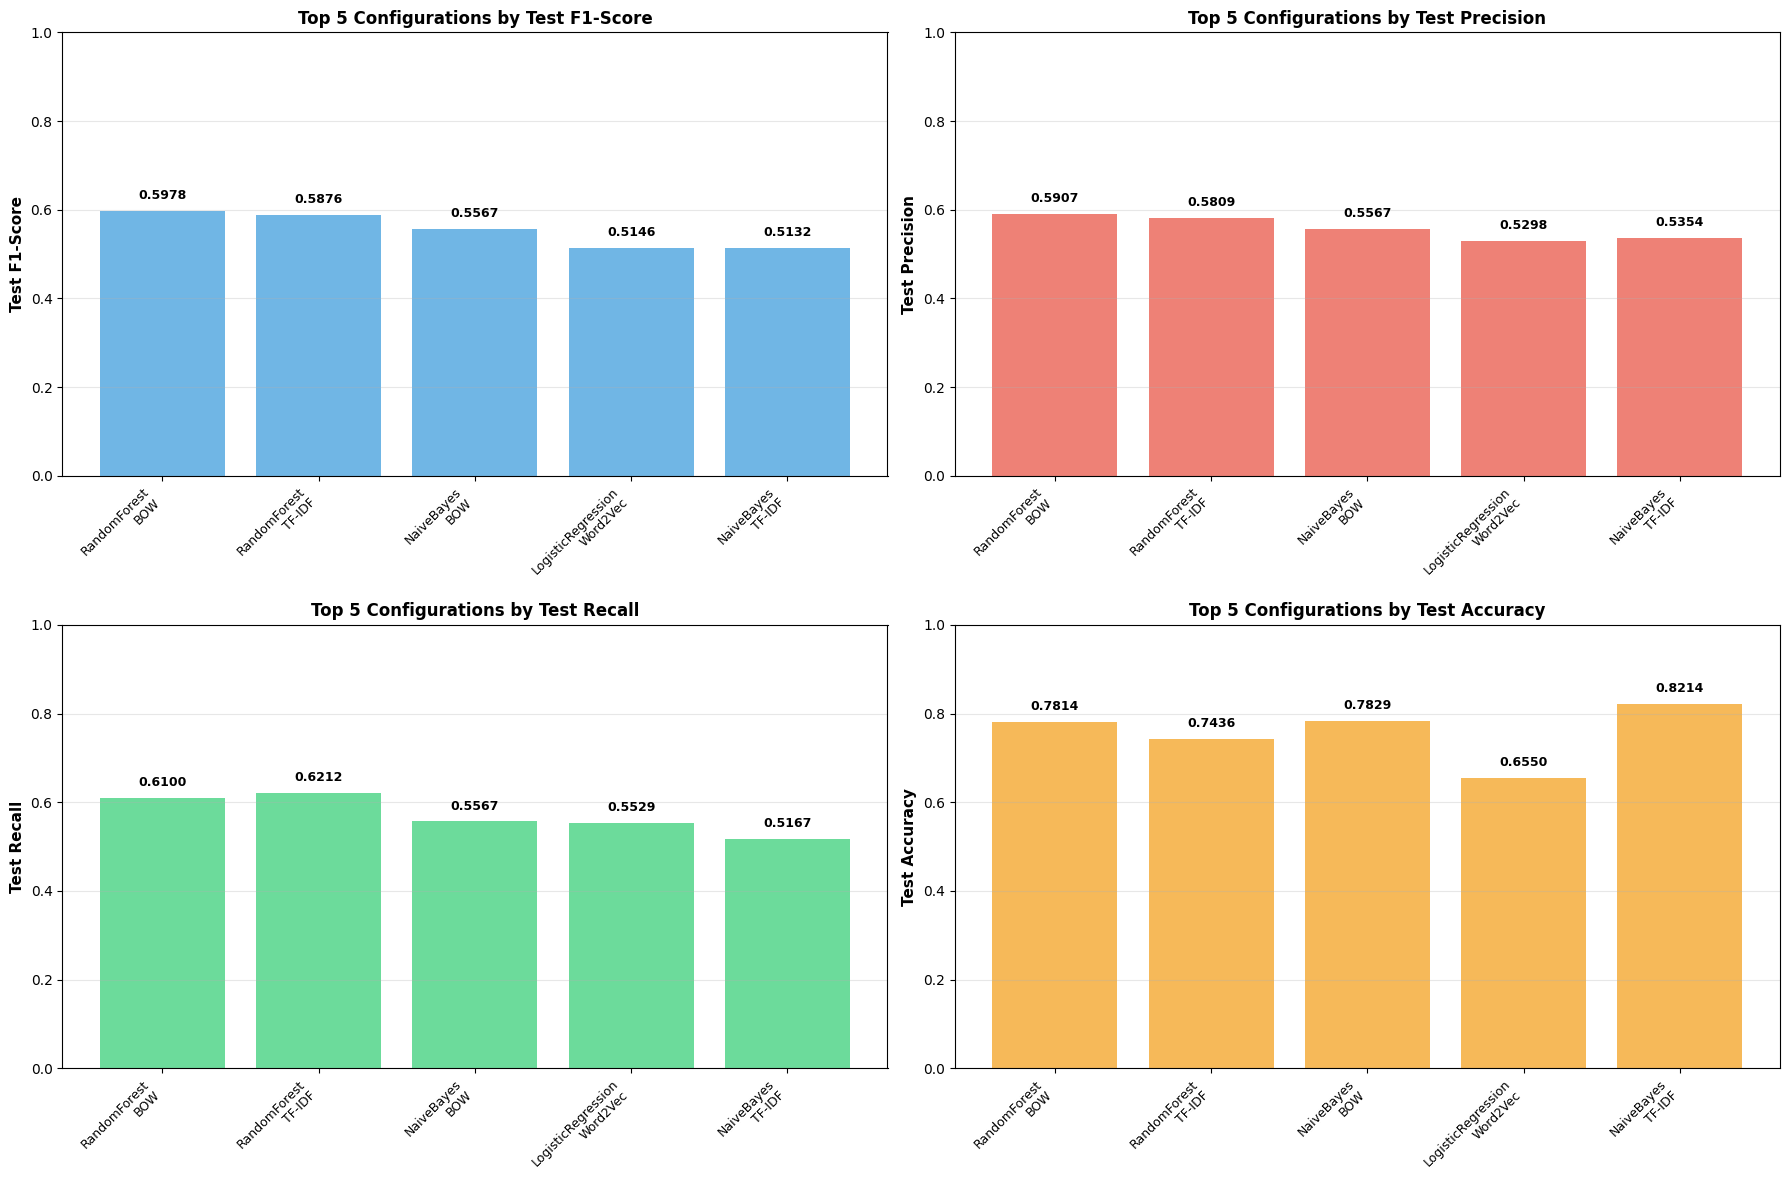

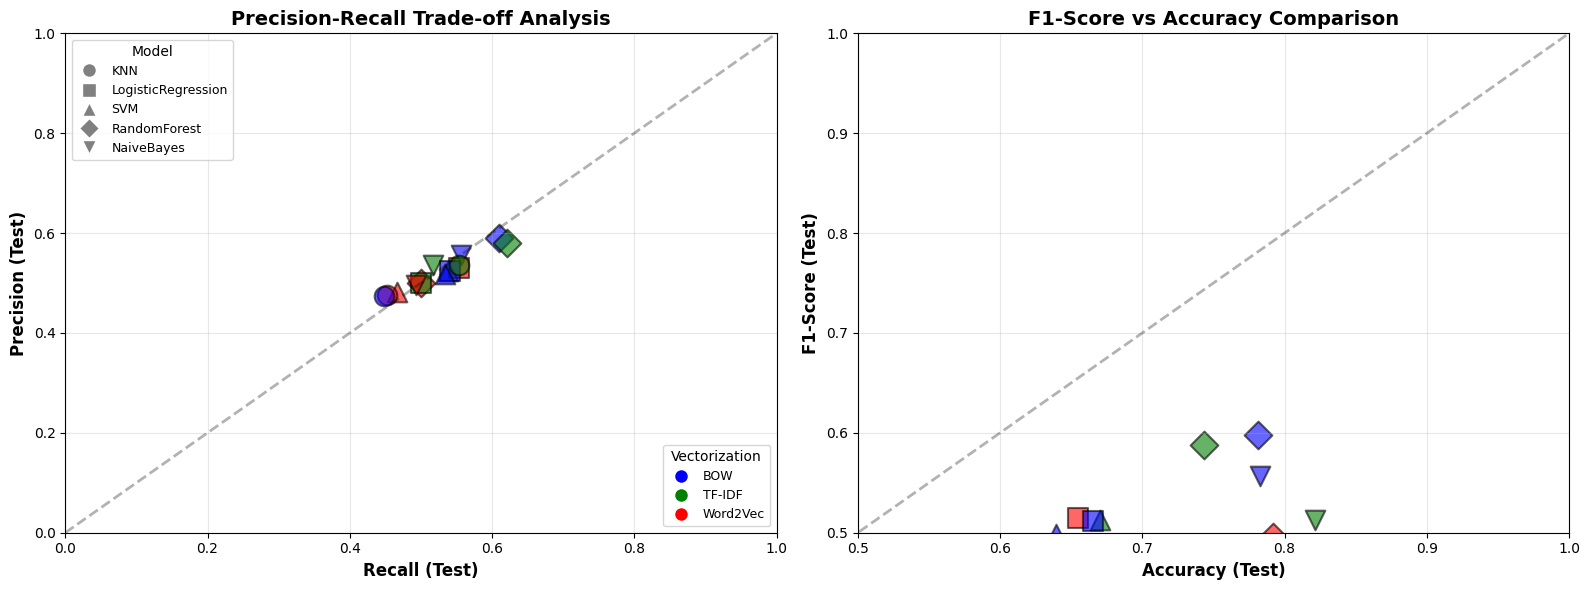

AVERAGE METRICS BY MODEL TYPE
                     Test_F1  Test_Precision  Test_Recall  Test_Accuracy
Model                                                                   
RandomForest        0.560525        0.556994     0.576944       0.772381
NaiveBayes          0.512565        0.529329     0.521944       0.737619
LogisticRegression  0.502795        0.518019     0.531389       0.653810
SVM                 0.483715        0.508008     0.512639       0.624048
KNN                 0.384110        0.495360     0.484444       0.447143


AVERAGE METRICS BY VECTORIZATION METHOD
                Test_F1  Test_Precision  Test_Recall  Test_Accuracy
Vectorization                                                      
BOW            0.511960        0.532826     0.537667       0.667429
TF-IDF         0.485894        0.535070     0.546083       0.643286
Word2Vec       0.468372        0.496731     0.492667       0.630286




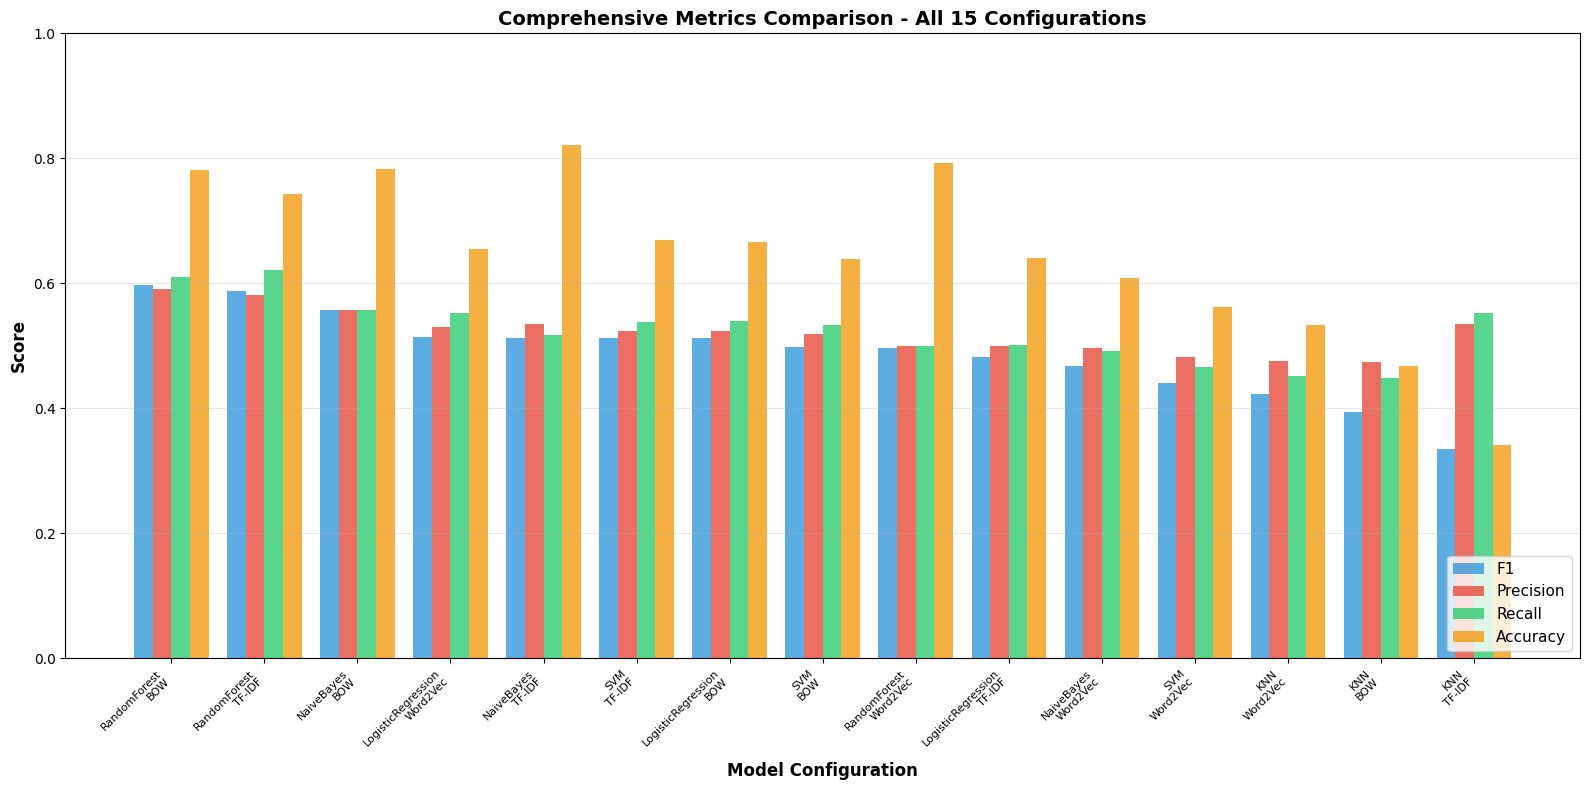

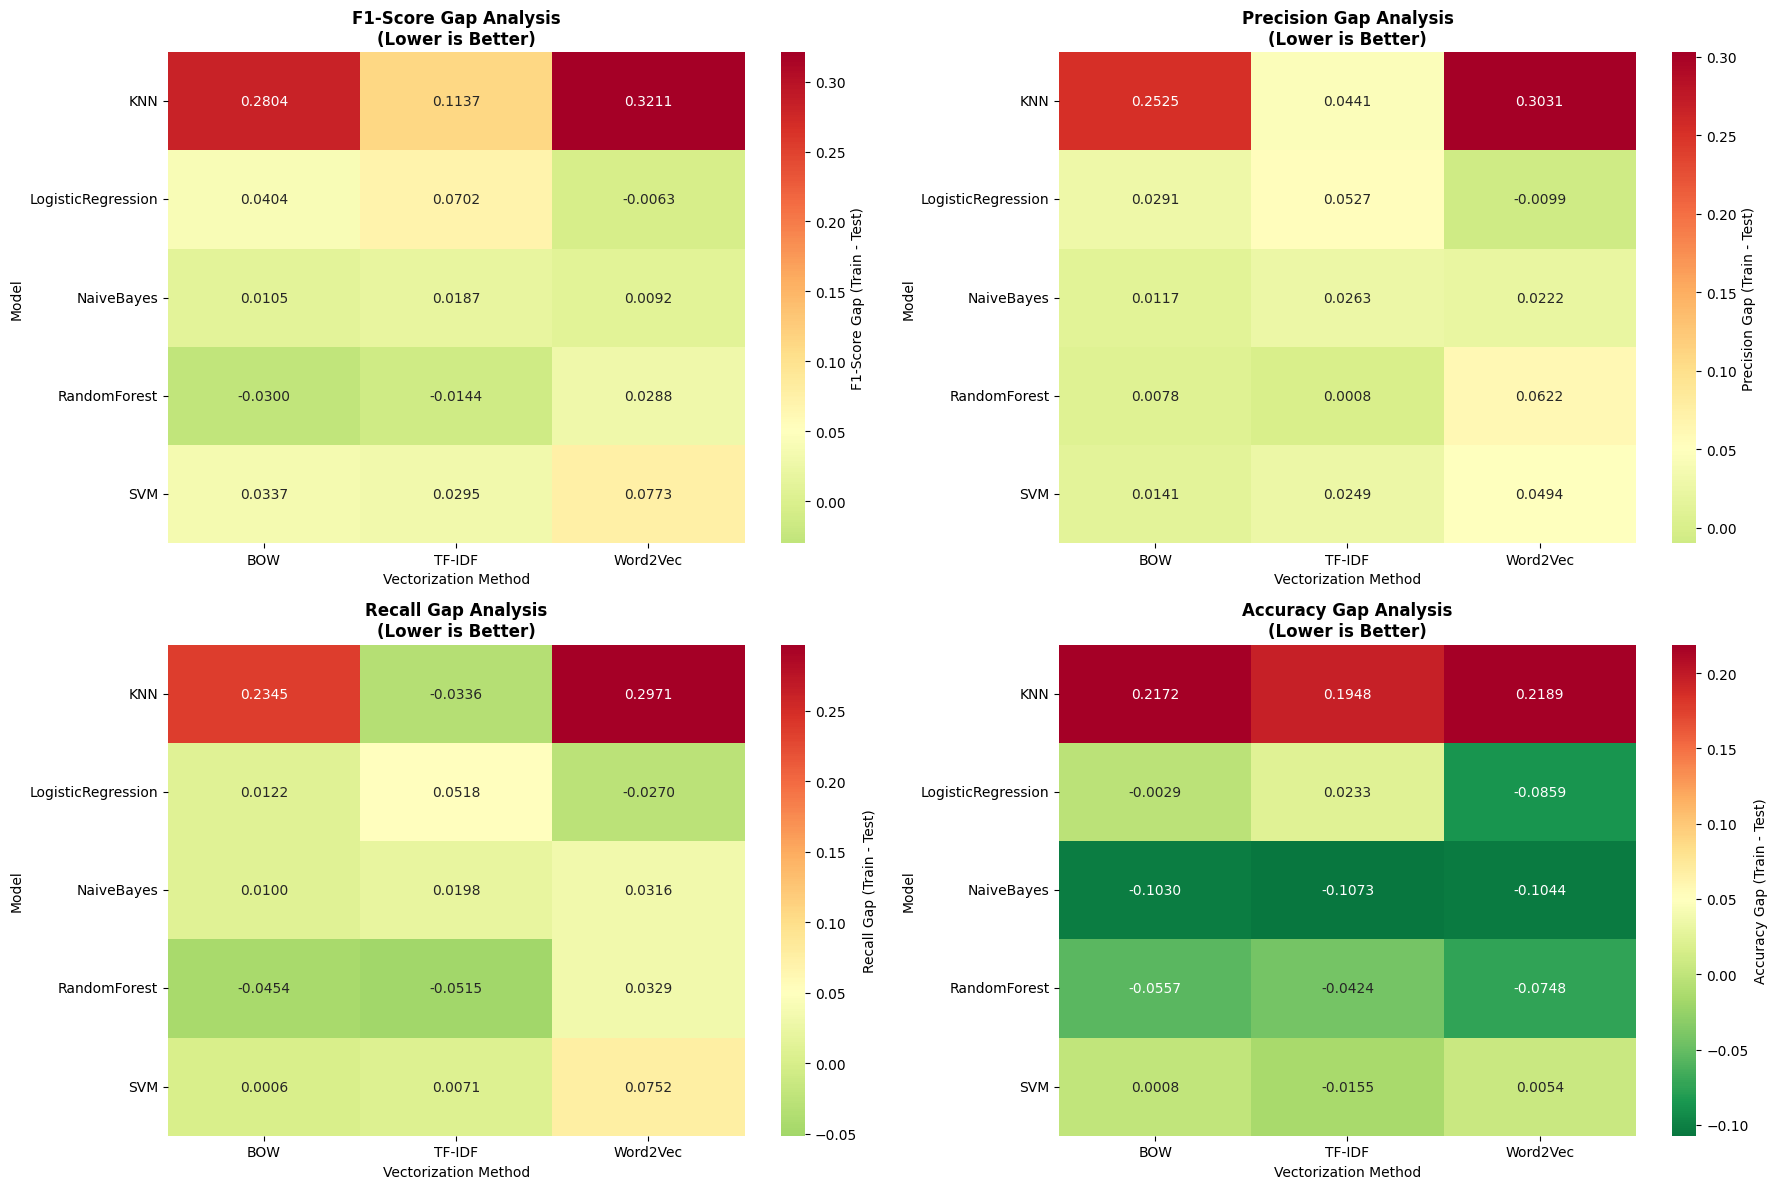

COMPREHENSIVE MULTI-METRIC ANALYSIS COMPLETE


In [38]:
# Comprehensive Multi-Metric Performance Analysis

# 1. Create detailed metrics DataFrame
detailed_metrics_data = []

for model_name, vectorizations in results.items():
    for vec_name, scores in vectorizations.items():
        detailed_metrics_data.append({
            'Model': model_name,
            'Vectorization': vec_name,
            'Test_F1': scores['Test_F1'],
            'Test_Precision': scores['Test_Precision'],
            'Test_Recall': scores['Test_Recall'],
            'Test_Accuracy': scores['Test_Accuracy'],
            'Train_F1': scores['Train_F1'],
            'Train_Precision': scores['Train_Precision'],
            'Train_Recall': scores['Train_Recall'],
            'Train_Accuracy': scores['Train_Accuracy'],
            'Overfitting_Gap': scores['Train_F1'] - scores['Test_F1'],
            'Precision_Gap': scores['Train_Precision'] - scores['Test_Precision'],
            'Recall_Gap': scores['Train_Recall'] - scores['Test_Recall'],
            'Accuracy_Gap': scores['Train_Accuracy'] - scores['Test_Accuracy']
        })

metrics_df = pd.DataFrame(detailed_metrics_data)
metrics_df = metrics_df.sort_values('Test_F1', ascending=False)

print("="*100)
print("COMPREHENSIVE METRICS SUMMARY - ALL 15 CONFIGURATIONS")
print("="*100)
print("\nTest Set Performance (Primary Evaluation):")
print(metrics_df[['Model', 'Vectorization', 'Test_F1', 'Test_Precision',
                   'Test_Recall', 'Test_Accuracy']].to_string(index=False))
print("\n")

print("="*100)
print("GENERALIZATION ANALYSIS (Train-Test Gaps)")
print("="*100)
print(metrics_df[['Model', 'Vectorization', 'Overfitting_Gap', 'Precision_Gap',
                   'Recall_Gap', 'Accuracy_Gap']].to_string(index=False))
print("\n")

# 2. Statistical Summary by Metric
print("="*100)
print("TEST METRICS STATISTICS")
print("="*100)
print("\nF1-Score Statistics:")
print(f"  Best:    {metrics_df['Test_F1'].max():.4f} ({metrics_df.loc[metrics_df['Test_F1'].idxmax(), 'Model']} - {metrics_df.loc[metrics_df['Test_F1'].idxmax(), 'Vectorization']})")
print(f"  Worst:   {metrics_df['Test_F1'].min():.4f} ({metrics_df.loc[metrics_df['Test_F1'].idxmin(), 'Model']} - {metrics_df.loc[metrics_df['Test_F1'].idxmin(), 'Vectorization']})")
print(f"  Mean:    {metrics_df['Test_F1'].mean():.4f}")
print(f"  Median:  {metrics_df['Test_F1'].median():.4f}")
print(f"  Std Dev: {metrics_df['Test_F1'].std():.4f}")

print("\nPrecision Statistics:")
print(f"  Best:    {metrics_df['Test_Precision'].max():.4f} ({metrics_df.loc[metrics_df['Test_Precision'].idxmax(), 'Model']} - {metrics_df.loc[metrics_df['Test_Precision'].idxmax(), 'Vectorization']})")
print(f"  Worst:   {metrics_df['Test_Precision'].min():.4f}")
print(f"  Mean:    {metrics_df['Test_Precision'].mean():.4f}")
print(f"  Median:  {metrics_df['Test_Precision'].median():.4f}")

print("\nRecall Statistics:")
print(f"  Best:    {metrics_df['Test_Recall'].max():.4f} ({metrics_df.loc[metrics_df['Test_Recall'].idxmax(), 'Model']} - {metrics_df.loc[metrics_df['Test_Recall'].idxmax(), 'Vectorization']})")
print(f"  Worst:   {metrics_df['Test_Recall'].min():.4f}")
print(f"  Mean:    {metrics_df['Test_Recall'].mean():.4f}")
print(f"  Median:  {metrics_df['Test_Recall'].median():.4f}")

print("\nAccuracy Statistics:")
print(f"  Best:    {metrics_df['Test_Accuracy'].max():.4f} ({metrics_df.loc[metrics_df['Test_Accuracy'].idxmax(), 'Model']} - {metrics_df.loc[metrics_df['Test_Accuracy'].idxmax(), 'Vectorization']})")
print(f"  Worst:   {metrics_df['Test_Accuracy'].min():.4f}")
print(f"  Mean:    {metrics_df['Test_Accuracy'].mean():.4f}")
print(f"  Median:  {metrics_df['Test_Accuracy'].median():.4f}")
print("\n")

# 3. Multi-Metric Heatmaps
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

metrics_to_plot = ['Test_F1', 'Test_Precision', 'Test_Recall', 'Test_Accuracy']
titles = ['F1-Score (Test)', 'Precision (Test)', 'Recall (Test)', 'Accuracy (Test)']
cmaps = ['YlGnBu', 'YlOrRd', 'Greens', 'Purples']

for idx, (metric, title, cmap) in enumerate(zip(metrics_to_plot, titles, cmaps)):
    ax = axes[idx // 2, idx % 2]
    pivot = metrics_df.pivot(index='Model', columns='Vectorization', values=metric)
    sns.heatmap(pivot, annot=True, fmt='.4f', cmap=cmap, ax=ax,
                cbar_kws={'label': title}, vmin=0, vmax=1)
    ax.set_title(f'{title} Heatmap: Models vs Vectorization', fontsize=12, fontweight='bold')
    ax.set_xlabel('Vectorization Method', fontsize=10)
    ax.set_ylabel('Model', fontsize=10)

plt.tight_layout()
plt.show()

# 4. Metric Comparison Bar Charts
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

top_5_configs = metrics_df.head(5).copy()
top_5_configs['Config'] = top_5_configs['Model'] + '\n' + top_5_configs['Vectorization']

metrics_for_bars = [
    ('Test_F1', 'Test F1-Score', '#3498db'),
    ('Test_Precision', 'Test Precision', '#e74c3c'),
    ('Test_Recall', 'Test Recall', '#2ecc71'),
    ('Test_Accuracy', 'Test Accuracy', '#f39c12')
]

for idx, (metric, title, color) in enumerate(metrics_for_bars):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(range(len(top_5_configs)), top_5_configs[metric], color=color, alpha=0.7)
    ax.set_xticks(range(len(top_5_configs)))
    ax.set_xticklabels(top_5_configs['Config'], rotation=45, ha='right', fontsize=9)
    ax.set_ylabel(title, fontsize=11, fontweight='bold')
    ax.set_title(f'Top 5 Configurations by {title}', fontsize=12, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, top_5_configs[metric])):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{value:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# 5. Precision-Recall Trade-off Analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot: Precision vs Recall
ax = axes[0]
colors_map = {'BOW': 'blue', 'TF-IDF': 'green', 'Word2Vec': 'red'}
markers_map = {'KNN': 'o', 'LogisticRegression': 's', 'SVM': '^',
               'RandomForest': 'D', 'NaiveBayes': 'v'}

for _, row in metrics_df.iterrows():
    ax.scatter(row['Test_Recall'], row['Test_Precision'],
              c=colors_map[row['Vectorization']],
              marker=markers_map[row['Model']],
              s=200, alpha=0.6, edgecolors='black', linewidth=1.5)

# Add diagonal line (where precision = recall)
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=2, label='Precision = Recall')

ax.set_xlabel('Recall (Test)', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision (Test)', fontsize=12, fontweight='bold')
ax.set_title('Precision-Recall Trade-off Analysis', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Add legends
from matplotlib.lines import Line2D
legend_vec = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color,
                     markersize=10, label=vec) for vec, color in colors_map.items()]
legend_models = [Line2D([0], [0], marker=marker, color='w', markerfacecolor='gray',
                        markersize=10, label=model) for model, marker in markers_map.items()]
first_legend = ax.legend(handles=legend_vec, loc='lower right', title='Vectorization', fontsize=9)
ax.add_artist(first_legend)
ax.legend(handles=legend_models, loc='upper left', title='Model', fontsize=9)

# F1 vs Accuracy comparison
ax = axes[1]
for _, row in metrics_df.iterrows():
    ax.scatter(row['Test_Accuracy'], row['Test_F1'],
              c=colors_map[row['Vectorization']],
              marker=markers_map[row['Model']],
              s=200, alpha=0.6, edgecolors='black', linewidth=1.5)

ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=2)
ax.set_xlabel('Accuracy (Test)', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score (Test)', fontsize=12, fontweight='bold')
ax.set_title('F1-Score vs Accuracy Comparison', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xlim(0.5, 1)
ax.set_ylim(0.5, 1)

plt.tight_layout()
plt.show()

# 6. Average Metrics by Model Type
print("="*100)
print("AVERAGE METRICS BY MODEL TYPE")
print("="*100)
model_avg = metrics_df.groupby('Model')[['Test_F1', 'Test_Precision', 'Test_Recall', 'Test_Accuracy']].mean()
model_avg = model_avg.sort_values('Test_F1', ascending=False)
print(model_avg.to_string())
print("\n")

# 7. Average Metrics by Vectorization
print("="*100)
print("AVERAGE METRICS BY VECTORIZATION METHOD")
print("="*100)
vec_avg = metrics_df.groupby('Vectorization')[['Test_F1', 'Test_Precision', 'Test_Recall', 'Test_Accuracy']].mean()
vec_avg = vec_avg.sort_values('Test_F1', ascending=False)
print(vec_avg.to_string())
print("\n")

# 8. Grouped Bar Chart - All Metrics Comparison
fig, ax = plt.subplots(figsize=(16, 8))

x = np.arange(len(metrics_df))
width = 0.2

bars1 = ax.bar(x - 1.5*width, metrics_df['Test_F1'], width, label='F1', alpha=0.8, color='#3498db')
bars2 = ax.bar(x - 0.5*width, metrics_df['Test_Precision'], width, label='Precision', alpha=0.8, color='#e74c3c')
bars3 = ax.bar(x + 0.5*width, metrics_df['Test_Recall'], width, label='Recall', alpha=0.8, color='#2ecc71')
bars4 = ax.bar(x + 1.5*width, metrics_df['Test_Accuracy'], width, label='Accuracy', alpha=0.8, color='#f39c12')

ax.set_xlabel('Model Configuration', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Comprehensive Metrics Comparison - All 15 Configurations', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_df['Model'] + '\n' + metrics_df['Vectorization'],
                   rotation=45, ha='right', fontsize=8)
ax.legend(fontsize=11, loc='lower right')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# 9. Gap Analysis for All Metrics
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

gap_metrics = [
    ('Overfitting_Gap', 'F1-Score Gap', '#3498db'),
    ('Precision_Gap', 'Precision Gap', '#e74c3c'),
    ('Recall_Gap', 'Recall Gap', '#2ecc71'),
    ('Accuracy_Gap', 'Accuracy Gap', '#f39c12')
]

for idx, (metric, title, color) in enumerate(gap_metrics):
    ax = axes[idx // 2, idx % 2]
    pivot = metrics_df.pivot(index='Model', columns='Vectorization', values=metric)
    sns.heatmap(pivot, annot=True, fmt='.4f', cmap='RdYlGn_r', center=0.05,
                ax=ax, cbar_kws={'label': f'{title} (Train - Test)'})
    ax.set_title(f'{title} Analysis\n(Lower is Better)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Vectorization Method', fontsize=10)
    ax.set_ylabel('Model', fontsize=10)

plt.tight_layout()
plt.show()

print("="*100)
print("COMPREHENSIVE MULTI-METRIC ANALYSIS COMPLETE")
print("="*100)